# Semester Project

This notebook is the final notebook with the last results. This jupyter notebook contains the code for: 
- the transformation/normalisation of data (for tests on affected and unaffected sides)
- the min max normalisation of all tests
- the adaptation of each test to make sure all tests can be interpreted in the same way (the higher the score of the tests, the more impaired the patient is)
- the computation of the NMF transformation based on timepoint 1
- the transformation at all other timepoints using the NMF transformation of T1
- the clustering of the patients based on time T1
- the classification of patients at all timepoints based on the clusters found at T1
- the computation of a probability to be in a certain clusters
- the analysis of the evolution of two specific patients

NOTE : In this notebook the executive and memory domains have been merge into 1 domain

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from scipy.stats import mannwhitneyu
from scipy import stats
from scipy.linalg import svd
import re
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from pandas.plotting import scatter_matrix
#import plotly.express as ex


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# To make this notebook's output stable across runs
np.random.seed(255)

### Important Choices for the following 

In [2]:
# To include or not LAST scores in the language tests
include_LAST_scores = False 
# To choose to have only LAST scores in the language tests
LAST_scores_no_language = False # If True, include_LAST_scores does not make sense and has to be set to False
# To cloose to merge the memory and executive tests
merge_memory_executive = True

### Define useful functions

In [3]:
# Normalisation function for paired and single data
def norm(X, affected_list, unaffected_list, paired_norm):
    """
    This function normalizes the data based on the formula from the paper https://www.biorxiv.org/content/10.1101/2022.05.23.493043v1.abstract
    The function takes in the data, the list of affected and unaffected column names and paired_norm, the new list of column names for the normalized data
    Returns a dataframe with the normalized data and the column names
    """

    # create an empty dataframe
    norm_df = pd.DataFrame()

    # Normalize paired motor data based on formula from paper https://www.biorxiv.org/content/10.1101/2022.05.23.493043v1.abstract 
    # Pair motor data refers to the test for which the data was acquired both for the affected and unaffected side
    # if the all lists exist, the data is normalized
    if affected_list and unaffected_list and paired_norm:
        
            for af,unaf,col_name in zip(affected_list, unaffected_list, paired_norm):

                norm_df[col_name] = (X[unaf] - X[af])/(X[af] + X[unaf])

                if col_name == "Ashworth_norm" or col_name == "X9HPT_norm":

                    norm_df[col_name] = - norm_df[col_name]

                # NOTE: Mildly negative values are unlikely: we set negative values to 0
                norm_df[col_name] = norm_df[col_name].apply(lambda x: 0 if x < 0 else x)

    # check if negative values exist
    if (norm_df < 0).any().any():
        print('Negative values exist')

    # get the column names
    column_names = list(norm_df.columns)

    return norm_df, column_names

In [4]:
def motor_transform(df):
    ''' Normalizes the motor data and returns a dataframe with the normalized data and the column names''' 

    motor_affected =   ["Fugl.Meyer_affected_TOTAL", 
                        "P.G_affected_FIST_mean",
                        "B.B_blocks_affected_hand",
                        "Purdue_affected_hand"
                        ]

    motor_unaffected = ["Fugl.Meyer_unaffected_TOTAL",
                        "P.G_unaffected_FIST_mean",
                        "B.B_blocks_unaffected_hand",
                        "Purdue_unaffected_hand"
                        ]
    
    motor_paired_norm =["Fugl.Meyer_norm",
                        "P.G_FIST_norm",
                        "B.B_blocks_norm",
                        "Purdue_norm"
                        ]

    info = df[["Patient","Timepoint"]]

    norm_df, column_names = norm(df, affected_list = motor_affected, unaffected_list = motor_unaffected, paired_norm = motor_paired_norm)

    # add the patient and timepoint columns
    norm_df = pd.concat([info, norm_df], axis = 1)

    return norm_df, column_names

def sensory_transform(df):
    ''' Normalizes the sensory data and returns a dataframe with the normalized data and the column names'''
    
    sensory_affected =  ["RASP_affected_hand"]
    sensory_unaffected = ["RASP_unaffected_hand"]

    sensory_paired_norm =["RASP_norm"]

    info = df[["Patient","Timepoint"]]

    norm_df, column_names = norm(df, affected_list = sensory_affected, unaffected_list = sensory_unaffected, paired_norm = sensory_paired_norm)

    # add the patient and timepoint columns
    norm_df = pd.concat([info, norm_df], axis = 1)

    return norm_df, column_names


### Import the 4 TiMeS datasets (with non-missing data, imputed by Lisa) 

In [5]:
path = r'../Data/TiMeS_matrix_mdImputed_allT'+ str(1) +'.xlsx'
print(path)
datas_1=pd.read_excel(path)

path = r'../Data/TiMeS_matrix_mdImputed_allT'+ str(2) +'.xlsx'
print(path)
datas_2=pd.read_excel(path)

path = r'../Data/TiMeS_matrix_mdImputed_allT'+ str(3) +'.xlsx'
print(path)
datas_3=pd.read_excel(path)

path = r'../Data/TiMeS_matrix_mdImputed_allT'+ str(4) +'.xlsx'
print(path)
datas_4=pd.read_excel(path)

../Data/TiMeS_matrix_mdImputed_allT1.xlsx
../Data/TiMeS_matrix_mdImputed_allT2.xlsx
../Data/TiMeS_matrix_mdImputed_allT3.xlsx
../Data/TiMeS_matrix_mdImputed_allT4.xlsx


### Define the list of tests for each domains

In [6]:
memory_col = ['Digit_forward_TOTAL_norm', 'Corsi_forward_TOTAL_norm']

motor_col = ['Fugl.Meyer_norm', 'P.G_FIST_norm', 'B.B_blocks_norm', 'Purdue_norm']

attention_col = ['TAP_alert_without_warning_RT_norm',
                'TAP_divided_attention_single_condition_Auditive_RT_norm',
                'TAP_divided_attention_single_condition_Visual_RT_norm',
                'TAP_divided_attention_both_condition_Auditive_RT_norm',
                'TAP_divided_attention_both_condition_Visual_RT_norm',
                'Bells_omissions_total_norm', 'CTM_A_time_norm']

executive_col = ['Bi.manual_coordination_corrected_norm', 'FAB_TOT_norm',
                'AST_unaffected_TOTAL_norm', 'CERAD_copy_TOTAL_norm',
                'Stroop_interference_time_norm', 'Digit_backward_TOTAL_norm',
                'Digit_sequencing_TOTAL_norm', 'Corsi_backward_TOTAL_norm',
                'CTM_B_time_norm'] 

sensory_col = ['RASP_norm']

language_col = ['Fluency_phon_final_score_norm', 'Fluency_sem_final_score_norm']
if include_LAST_scores:
    language_col = language_col + ['LAST_TOTAL_norm']
if LAST_scores_no_language:
    language_col = ['LAST_TOTAL_norm']

neglect_col = ['Line_bissec_20cm_norm', 'Line_bissec_.5cm_norm',
               'Bells_omissions_L.R_norm']

Merge the 4 timepoints into one dataframe:

In [7]:
#join the a datasets together
# add a column to each dataset to indicate the timepoint
datas_1['Timepoint'] = 1
datas_2['Timepoint'] = 2
datas_3['Timepoint'] = 3
datas_4['Timepoint'] = 4

datas = pd.concat([datas_1, datas_2, datas_3, datas_4], axis=0, ignore_index=True)
datas

,Patient,Fugl.Meyer_affected_UPPER_EXTREMITY,Fugl.Meyer_affected_WRIST,Fugl.Meyer_affected_HAND,Fugl.Meyer_affected_COORDINATION.SPEED,Fugl.Meyer_affected_TOTAL,P.G_affected_FIST_mean,P.G_affected_PINCH_mean,P.G_affected_KEY_mean,MRC_affected,...,Doors_total,X2min,X10m_confortable_speed,X10m_max_speed,TUG,X5pts_correct_productions,X5pts_perseverative_productions,X5pts_perseverations_.,X5pts_strategic_productions,X5pts_strategic_.
0,P001,30.0,10.0,14.0,4.0,58.0,45.333333,6.666667,6.833333,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P002,30.0,10.0,13.0,4.0,57.0,15.000000,2.333333,3.666667,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P003,30.0,10.0,14.0,6.0,60.0,34.000000,5.666667,8.000000,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P004,18.0,10.0,14.0,6.0,47.0,17.666667,3.500000,3.166667,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P005,30.0,10.0,14.0,5.0,59.0,36.333333,4.033333,5.566667,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,P076,30.0,10.0,14.0,6.0,60.0,15.666667,2.333333,4.083333,65.0,...,13.0,165.594401,1.083660,1.517823,11.924861,31.0,0.0,0.000000,8.0,25.806452
232,P077,23.0,8.0,14.0,3.0,48.0,14.333333,2.166667,3.250000,55.0,...,18.0,158.250000,1.073345,1.149425,12.720000,16.0,5.0,31.250000,3.0,18.750000
233,P079,26.0,9.0,14.0,5.0,54.0,20.666667,2.666667,4.500000,65.0,...,12.0,144.000000,1.102941,1.315789,10.220000,38.0,9.0,23.684211,6.0,15.789474
234,P081,30.0,10.0,14.0,6.0,60.0,37.000000,4.833333,7.666667,65.0,...,15.0,185.000000,1.546392,1.923077,6.720000,41.0,3.0,7.317073,31.0,75.609756


## Normalisation

Variable transformation: For all tests conducted on both sides by the patient, reduce them to one single variable. This is only the case for motor and sensory domains.

### Motor

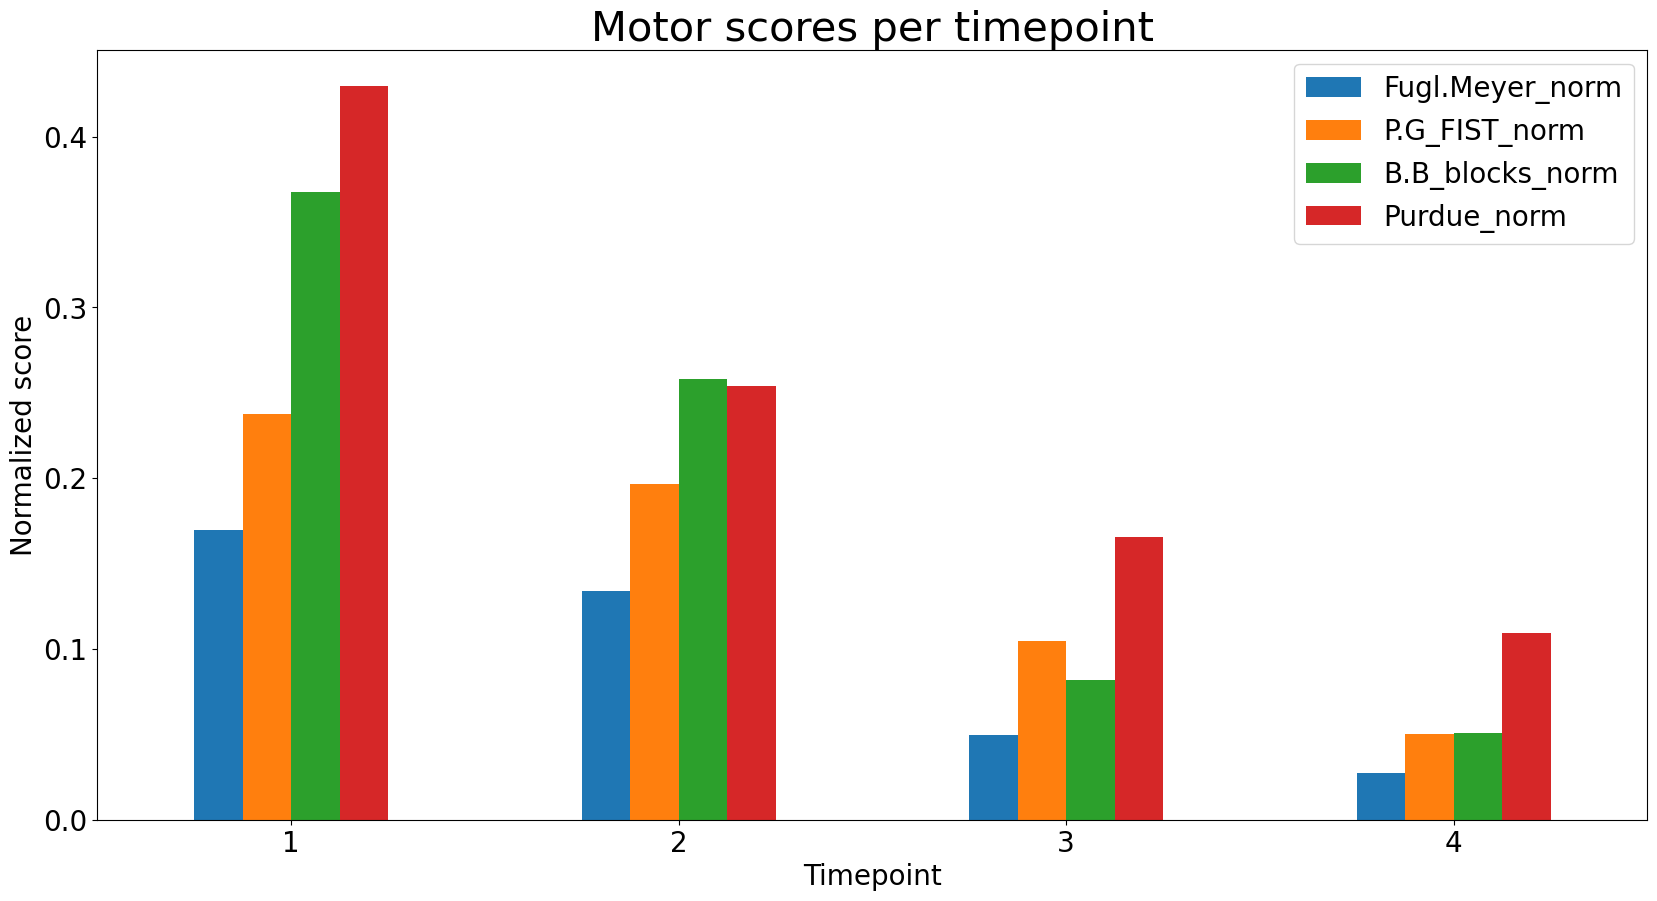

In [8]:
motor_df, columns = motor_transform(datas)

# plot the mean of motor columns per timepoint to check if the normalization worked
# Indeed the mean decreases over time, patients get better
motor_df.drop("Patient", axis=1).groupby('Timepoint').mean().plot.bar(figsize=(20,10), rot=0, fontsize=20)
plt.title('Motor scores per timepoint', fontsize=30)
plt.xlabel('Timepoint', fontsize=20)
plt.ylabel('Normalized score', fontsize=20)
plt.legend(fontsize=20)
plt.show()


In [9]:
# check if null values are present
motor_df.isnull().sum()

Patient            0
Timepoint          0
Fugl.Meyer_norm    0
P.G_FIST_norm      0
B.B_blocks_norm    0
Purdue_norm        0
dtype: int64

### Sensory

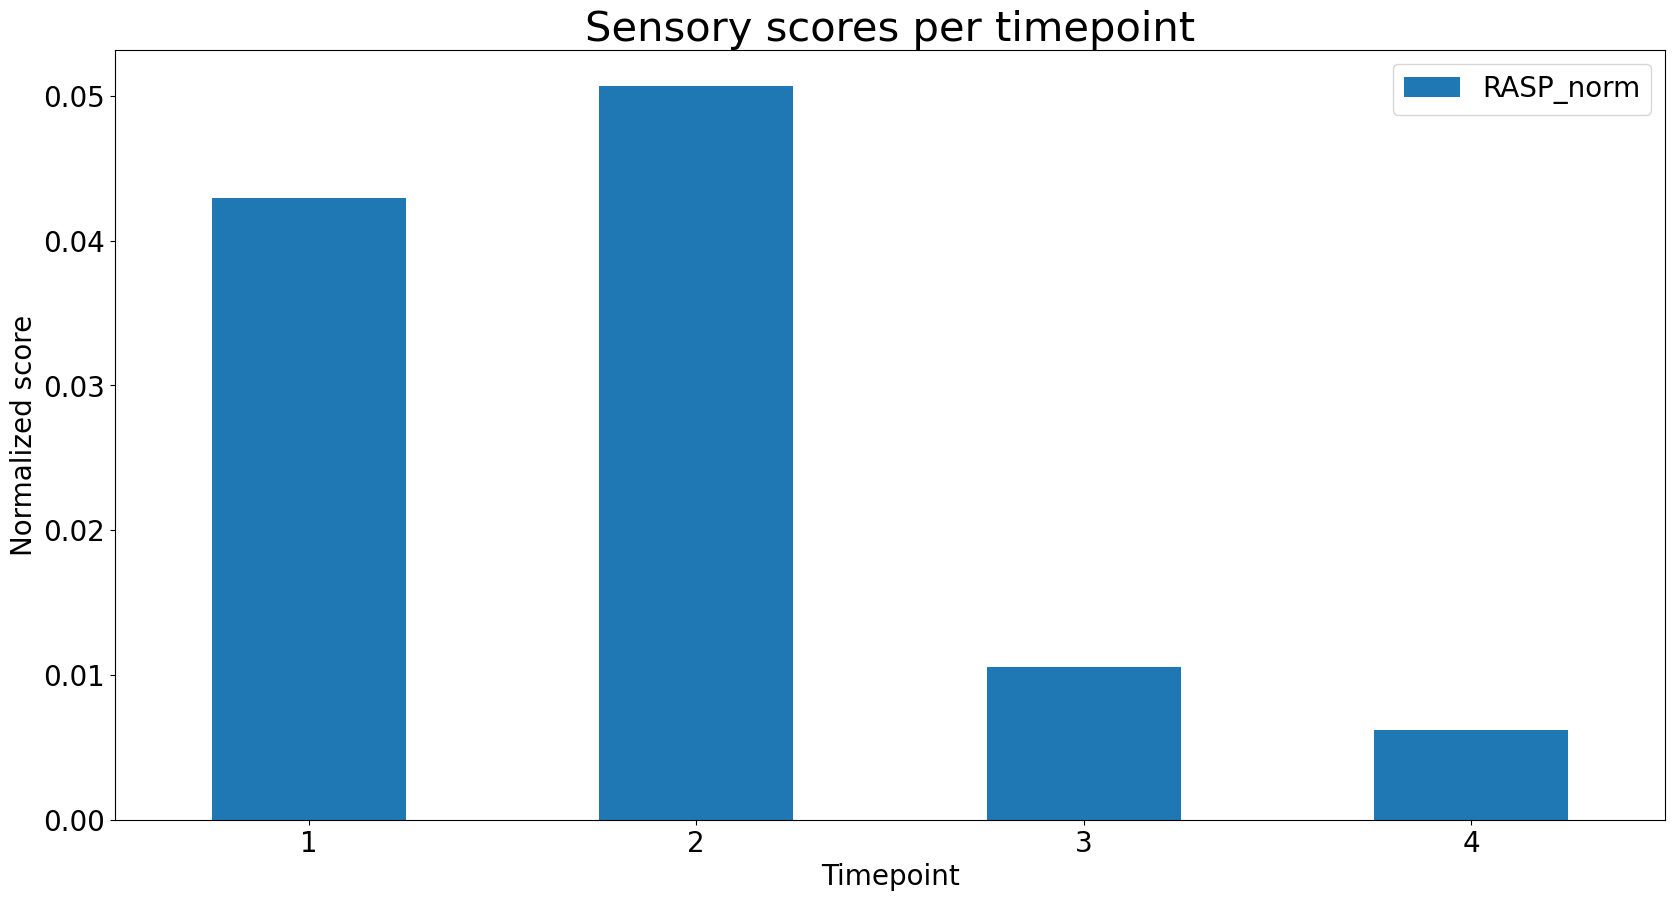

In [10]:
sensory_df, columns = sensory_transform(datas)

# plot the mean of sensory columns per timepoint to check if the normalization worked
# Indeed the mean decreases over time, patients get better
sensory_df.drop("Patient", axis=1).groupby('Timepoint').mean().plot.bar(figsize=(20,10), rot=0, fontsize=20)
plt.title('Sensory scores per timepoint', fontsize=30)
plt.xlabel('Timepoint', fontsize=20)
plt.ylabel('Normalized score', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [11]:
# check if null values are present
sensory_df.isnull().sum()

Patient      0
Timepoint    0
RASP_norm    0
dtype: int64

### General min-max normalization

In [12]:
attention_single = ["TAP_alert_without_warning_RT",   
                    "TAP_divided_attention_single_condition_Auditive_RT",
                    "TAP_divided_attention_single_condition_Visual_RT",
                    "TAP_divided_attention_both_condition_Auditive_RT", 
                    "TAP_divided_attention_both_condition_Visual_RT",
                    "Bells_omissions_total",
                    "CTM_A_time"]


executive_single = ["Bi.manual_coordination_corrected",
                    "FAB_TOT",
                    "AST_unaffected_TOTAL", 
                    "CERAD_copy_TOTAL",
                    "Stroop_interference_time",
                    "Digit_backward_TOTAL",
                    "Digit_sequencing_TOTAL",
                    "Corsi_backward_TOTAL",
                    "CTM_B_time"]

memory_single = ["Digit_forward_TOTAL", "Corsi_forward_TOTAL"]

language_single = ["Fluency_phon_final_score", "Fluency_sem_final_score"]
if include_LAST_scores:
    language_single = language_single + ["LAST_TOTAL"]
if LAST_scores_no_language:
    language_single = ["LAST_TOTAL"]

neglect_single =  ["Line_bissec_20cm", "Line_bissec_.5cm", "Bells_omissions_L.R"]

# create new lists by adding _norm to the end of each column name
attention_norm = [col + '_norm' for col in attention_single]
executive_norm = [col + '_norm' for col in executive_single]
memory_norm = [col + '_norm' for col in memory_single]
language_norm = [col + '_norm' for col in language_single]
neglect_norm = [col + '_norm' for col in neglect_single]




In [13]:
norm_data =datas[attention_single+executive_single+memory_single+language_single+neglect_single]

# add '_norm' to the column names
norm_data.columns = norm_data.columns + '_norm'
norm_data_domains = list(norm_data.columns)

# add patient and timepoint columns to norm_data
norm_data['Patient'] = datas['Patient']
norm_data['Timepoint'] = datas['Timepoint']

# add sensory and motor df to norm_data
norm_data = pd.merge(norm_data, motor_df, on=['Patient', 'Timepoint'])
norm_data = pd.merge(norm_data, sensory_df, on=['Patient', 'Timepoint'])

norm_data


,TAP_alert_without_warning_RT_norm,TAP_divided_attention_single_condition_Auditive_RT_norm,TAP_divided_attention_single_condition_Visual_RT_norm,TAP_divided_attention_both_condition_Auditive_RT_norm,TAP_divided_attention_both_condition_Visual_RT_norm,Bells_omissions_total_norm,CTM_A_time_norm,Bi.manual_coordination_corrected_norm,FAB_TOT_norm,AST_unaffected_TOTAL_norm,...,Line_bissec_20cm_norm,Line_bissec_.5cm_norm,Bells_omissions_L.R_norm,Patient,Timepoint,Fugl.Meyer_norm,P.G_FIST_norm,B.B_blocks_norm,Purdue_norm,RASP_norm
0,245.0,494.0,844.0,515.0,798.0,1.0,59.00,18.0,17.0,12.0,...,4.00,0.00,1.0,P001,1,0.008547,0.000000,0.010309,0.047619,0.000000
1,524.0,568.0,670.0,554.0,628.0,1.0,41.00,10.0,18.0,12.0,...,0.00,0.00,-1.0,P002,1,0.008696,0.126214,0.012658,0.285714,0.000000
2,345.0,483.0,1080.0,518.0,908.0,0.0,103.00,21.0,16.0,12.0,...,1.50,1.00,0.0,P003,1,0.000000,0.101322,0.037736,0.120000,0.000000
3,285.0,515.0,838.0,646.0,770.0,6.0,123.00,13.0,17.0,11.0,...,1.00,-1.00,-3.0,P004,1,0.000000,0.000000,0.100000,1.000000,0.033708
4,253.0,760.0,1242.0,824.0,942.0,3.0,66.00,35.0,18.0,12.0,...,6.50,1.00,-1.0,P005,1,0.008403,0.048035,0.023256,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,342.0,722.0,902.0,704.0,890.0,0.0,67.00,21.0,18.0,9.0,...,1.00,2.00,0.0,P076,4,0.000000,0.087379,0.000000,0.000000,0.000000
232,341.0,718.0,890.0,840.0,758.0,0.0,134.00,0.0,13.0,2.0,...,-2.00,0.50,0.0,P077,4,0.030303,0.104167,0.000000,0.000000,0.000000
233,354.0,743.0,1362.0,1116.0,1341.0,5.0,42.75,12.0,15.0,7.0,...,4.50,3.00,-1.0,P079,4,0.035714,0.074627,0.018519,0.090909,0.000000
234,247.0,0.0,0.0,651.0,790.0,0.0,23.34,31.0,18.0,12.0,...,0.75,0.75,0.0,P081,4,0.000000,0.022026,0.000000,0.000000,0.000000


In [14]:
# check if null values are present
norm_data.isnull().sum()[norm_data.isnull().sum() !=0]

Series([], dtype: int64)

In [15]:
norm_data_domains

['TAP_alert_without_warning_RT_norm',
 'TAP_divided_attention_single_condition_Auditive_RT_norm',
 'TAP_divided_attention_single_condition_Visual_RT_norm',
 'TAP_divided_attention_both_condition_Auditive_RT_norm',
 'TAP_divided_attention_both_condition_Visual_RT_norm',
 'Bells_omissions_total_norm',
 'CTM_A_time_norm',
 'Bi.manual_coordination_corrected_norm',
 'FAB_TOT_norm',
 'AST_unaffected_TOTAL_norm',
 'CERAD_copy_TOTAL_norm',
 'Stroop_interference_time_norm',
 'Digit_backward_TOTAL_norm',
 'Digit_sequencing_TOTAL_norm',
 'Corsi_backward_TOTAL_norm',
 'CTM_B_time_norm',
 'Digit_forward_TOTAL_norm',
 'Corsi_forward_TOTAL_norm',
 'Fluency_phon_final_score_norm',
 'Fluency_sem_final_score_norm',
 'Line_bissec_20cm_norm',
 'Line_bissec_.5cm_norm',
 'Bells_omissions_L.R_norm']

### Min-max normalization

In [16]:
X = norm_data.copy()

# neglect
# take absolute value of line bissec columns and bells omissions
X["Line_bissec_20cm_norm"] = X["Line_bissec_20cm_norm"].abs()
X["Line_bissec_.5cm_norm"] = X["Line_bissec_.5cm_norm"].abs()
X["Bells_omissions_L.R_norm"] = X["Bells_omissions_L.R_norm"].abs()

norm_data = X

# Apply min-max normalization of norm_data for each column except on patient and timepoint
norm_data[norm_data_domains + sensory_col + motor_col] = norm_data[norm_data_domains + sensory_col + motor_col].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

norm_data.describe()

,TAP_alert_without_warning_RT_norm,TAP_divided_attention_single_condition_Auditive_RT_norm,TAP_divided_attention_single_condition_Visual_RT_norm,TAP_divided_attention_both_condition_Auditive_RT_norm,TAP_divided_attention_both_condition_Visual_RT_norm,Bells_omissions_total_norm,CTM_A_time_norm,Bi.manual_coordination_corrected_norm,FAB_TOT_norm,AST_unaffected_TOTAL_norm,...,Fluency_sem_final_score_norm,Line_bissec_20cm_norm,Line_bissec_.5cm_norm,Bells_omissions_L.R_norm,Timepoint,Fugl.Meyer_norm,P.G_FIST_norm,B.B_blocks_norm,Purdue_norm,RASP_norm
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,...,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,0.178059,0.280907,0.583766,0.227155,0.356795,0.126404,0.138588,0.384058,0.789720,0.850458,...,0.363761,0.066886,0.043788,0.106910,2.296610,0.105799,0.119482,0.019563,0.031531,0.030737
std,0.148028,0.094450,0.133173,0.131780,0.219091,0.146234,0.119460,0.165967,0.218379,0.194613,...,0.173197,0.111331,0.078349,0.134392,1.109413,0.251976,0.206793,0.073829,0.073997,0.102711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074684,0.227656,0.490442,0.151038,0.192149,0.030303,0.074058,0.241070,0.727273,0.796766,...,0.239130,0.019481,0.016667,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.131646,0.272766,0.552788,0.209735,0.289256,0.090909,0.102335,0.371920,0.818182,0.956119,...,0.347826,0.038961,0.033333,0.076923,2.000000,0.008696,0.039777,0.004524,0.012069,0.000000
75%,0.223734,0.308600,0.660980,0.263422,0.491477,0.181818,0.170694,0.488231,1.000000,0.956119,...,0.478261,0.068994,0.050000,0.153846,3.000000,0.043671,0.096754,0.013224,0.029094,0.021277
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Making sure all tests are interpreted in the same way: the higher the score, the more impaired the patient is

In [17]:
X = norm_data.copy()

# execution data
# transform data where more is better to more is worse for FAB_TOT, AST_unaffected_TOTAL, CERAD_copy_TOTAL, digit_backward_TOTAL, digit_sequencing_TOTAL, corsi_backward_TOTAL
X["Bi.manual_coordination_corrected_norm"] = 1 - X["Bi.manual_coordination_corrected_norm"]
X["FAB_TOT_norm"] = 1 - X["FAB_TOT_norm"]
X["AST_unaffected_TOTAL_norm"] = 1 - X["AST_unaffected_TOTAL_norm"]
X["CERAD_copy_TOTAL_norm"] = 1 - X["CERAD_copy_TOTAL_norm"]
X["Digit_backward_TOTAL_norm"] = 1 - X["Digit_backward_TOTAL_norm"]
X["Digit_sequencing_TOTAL_norm"] = 1 - X["Digit_sequencing_TOTAL_norm"]
X["Corsi_backward_TOTAL_norm"] = 1 - X["Corsi_backward_TOTAL_norm"]

# memory data
# transform data where more is better to more is worse for digit_forward_TOTAL, corsi_forward_TOTAL
X["Digit_forward_TOTAL_norm"] = 1 - X["Digit_forward_TOTAL_norm"]
X["Corsi_forward_TOTAL_norm"] = 1 - X["Corsi_forward_TOTAL_norm"]

# language
if not LAST_scores_no_language:
    X["Fluency_phon_final_score_norm"] = 1 - X["Fluency_phon_final_score_norm"]
    X["Fluency_sem_final_score_norm"] = 1 - X["Fluency_sem_final_score_norm"]
if include_LAST_scores or LAST_scores_no_language:
    X["LAST_TOTAL_norm"] = 1 - X["LAST_TOTAL_norm"]

norm_data = X

### Estimate NMF transformation based on timepoint 1


In [18]:
def apply_NMF(df, n_components, col_names):
    """
    Apply NMF to the df and return the new dataset with the new features
    """

    # Finally we use NMF to reduce the N tests into 1 component
    model = NMF(n_components=n_components, random_state=5)

    # select the columns used to compute the NMF
    X = df[col_names]

    print('Nb of features in the initial data', X.shape[1])
    
    # Fit the model to the df
    model.fit(X) 
    print(model.fit(X))
    
    # Transform to nmf_features
    nmf_features = model.transform(X)

    print('New number of features', nmf_features.shape[1])
    print('New dataset size', nmf_features.shape)

    print("Print the value of the components", model.components_)
    print("Error of the projection", model.reconstruction_err_)

    return nmf_features, model

In [19]:
# keep only T1
norm_data_timepoint_1 = norm_data[norm_data['Timepoint'] == 1]

In [20]:
NMF_motor, model_motor = apply_NMF(norm_data_timepoint_1, n_components = 1, col_names = motor_col);

Nb of features in the initial data 4
NMF(n_components=1, random_state=5)
New number of features 1
New dataset size (74, 1)
Print the value of the components [[1.47726472 1.28076862 0.31228066 0.3791656 ]]
Error of the projection 1.459047014819557


In [21]:
NMF_attention, model_attention = apply_NMF(norm_data_timepoint_1, n_components = 1, col_names = attention_col);

Nb of features in the initial data 7
NMF(n_components=1, random_state=5)
New number of features 1
New dataset size (74, 1)
Print the value of the components [[0.76515914 0.92630359 1.95335183 0.79495944 1.2821952  0.55917671
  0.51328026]]
Error of the projection 2.571809386185038


In [22]:
# ATTENTION: we use the executive_col + memory_col to compute the NMF
if merge_memory_executive:
    NMF_executive, model_executive = apply_NMF(norm_data_timepoint_1, n_components = 1, col_names = executive_col + memory_col);
else:
    NMF_executive, model_executive = apply_NMF(norm_data_timepoint_1, n_components = 1, col_names = executive_col);
    NMF_memory, model_memory = apply_NMF(norm_data_timepoint_1, n_components = 1, col_names = memory_col);


Nb of features in the initial data 11
NMF(n_components=1, random_state=5)
New number of features 1
New dataset size (74, 1)
Print the value of the components [[1.57282513 0.84504124 0.49608148 0.54945174 0.70138656 1.14465243
  1.35016316 1.27479723 0.92189441 1.19664603 1.15552443]]
Error of the projection 3.9573555367070528


In [23]:
NMF_language, model_language = apply_NMF( norm_data_timepoint_1, n_components = 1, col_names = language_col);


Nb of features in the initial data 2
NMF(n_components=1, random_state=5)
New number of features 1
New dataset size (74, 1)
Print the value of the components [[1.84310574 2.07296388]]
Error of the projection 1.0795746048543007


In [24]:
NMF_neglect, model_neglect = apply_NMF(norm_data_timepoint_1, n_components = 1, col_names = neglect_col);


Nb of features in the initial data 3
NMF(n_components=1, random_state=5)
New number of features 1
New dataset size (74, 1)
Print the value of the components [[0.81221175 0.63710669 1.04734261]]
Error of the projection 1.5050273337686704


In [25]:
model_list = [model_motor, model_attention, model_executive, model_language, model_neglect]
if not merge_memory_executive:
    model_list.append(model_memory)

### Apply NMF transformation computed above, to all the timepoints

In [26]:
import pandas as pd
# import linalg

norm_list_timepoint_motor = []
norm_list_timepoint_attention = []
norm_list_timepoint_sensory = []
norm_list_timepoint_executive = []
norm_list_timepoint_memory = []
norm_list_timepoint_language = []
norm_list_timepoint_neglect = []
norm_list_timepoint_patient = []    

# Divide the normalised data into timepoints
for i in range(1,5):
    
    norm_list_timepoint = norm_data[norm_data['Timepoint'] == i]

    norm_list_timepoint_motor.append(norm_list_timepoint[motor_col])
    norm_list_timepoint_attention.append(norm_list_timepoint[attention_col])
    norm_list_timepoint_sensory.append(norm_list_timepoint[sensory_col])
    if merge_memory_executive:
        norm_list_timepoint_executive.append(norm_list_timepoint[executive_col + memory_col])
    else:
        norm_list_timepoint_executive.append(norm_list_timepoint[executive_col])
        norm_list_timepoint_memory.append(norm_list_timepoint[memory_col])
    norm_list_timepoint_language.append(norm_list_timepoint[language_col])
    norm_list_timepoint_neglect.append(norm_list_timepoint[neglect_col])
                                                            
    # add patient column
    norm_list_timepoint_patient.append(norm_list_timepoint['Patient'])

# list of lists HERE
if merge_memory_executive:
    norm_list = [norm_list_timepoint_motor, norm_list_timepoint_attention,norm_list_timepoint_executive,norm_list_timepoint_language,norm_list_timepoint_neglect,norm_list_timepoint_sensory,norm_list_timepoint_patient]
else :
    norm_list = [norm_list_timepoint_motor, norm_list_timepoint_attention,norm_list_timepoint_executive,norm_list_timepoint_language,norm_list_timepoint_neglect,norm_list_timepoint_memory, norm_list_timepoint_sensory,norm_list_timepoint_patient]

nmf_list_timepoint_attention = []
nmf_list_timepoint_executive = []
nmf_list_timepoint_memory = []
nmf_list_timepoint_motor = []
nmf_list_timepoint_language = []
nmf_list_timepoint_neglect = []

# apply nmf of time 1 to all the timepoints
for x, i,mod in zip(norm_list, range(len(norm_list)),model_list):
    
    # HERE
    # But only on the domains with more than 1 component 
    for j in range(len(x)):
        if i == 0:
            nmf_list_timepoint_motor.append(mod.transform(x[j]))
        elif i == 1:
            nmf_list_timepoint_attention.append(mod.transform(x[j]))
        elif i == 2:
            nmf_list_timepoint_executive.append(mod.transform(x[j]))
        elif i == 3:
            nmf_list_timepoint_language.append(mod.transform(x[j]))
        elif i == 4:
            nmf_list_timepoint_neglect.append(mod.transform(x[j]))
        elif i == 5:
            nmf_list_timepoint_memory.append(mod.transform(x[j]))


Store the reduced dataset per timepoint and the variance accounted for for each domain:

In [27]:

# measures the variance accounted for
def VAF (nmf, X, model):
    error = np.linalg.norm(nmf*model.components_-X, ord='fro')
    vaf = 1 - error**2/np.linalg.norm(X, ord = 'fro')**2

    return vaf

vaf = []
NMF_per_timepoint = []
norm_list_columns = ['motor', 'attention', 'executive', 'sensory', 'language', 'neglect', 'Patient']

nmf = pd.DataFrame()
for i in range(4):

    # concatenate the nmf of all the domains for each timepoint
    nmf = pd.concat([pd.DataFrame(nmf_list_timepoint_motor[i]).reset_index(drop=True),
                     pd.DataFrame(nmf_list_timepoint_attention[i]).reset_index(drop=True),
                     pd.DataFrame(nmf_list_timepoint_executive[i]).reset_index(drop=True),
                     pd.DataFrame(norm_list_timepoint_sensory[i]).reset_index(drop=True),
                     pd.DataFrame(nmf_list_timepoint_language[i]).reset_index(drop=True),
                     pd.DataFrame(nmf_list_timepoint_neglect[i]).reset_index(drop=True) ,
                     pd.DataFrame(norm_list_timepoint_patient[i]).reset_index(drop=True)],
                     axis=1)
    if not merge_memory_executive:
        nmf = pd.concat([nmf, pd.DataFrame(nmf_list_timepoint_memory[i]).reset_index(drop=True)], axis=1)

    # only measured for tests with more than 1 component, to which the nmf was applied
    vaf.append([VAF(nmf_list_timepoint_motor[i],norm_list_timepoint_motor[i],model_list[0]),
                VAF(nmf_list_timepoint_attention[i],norm_list_timepoint_attention[i],model_list[1]), 
                VAF(nmf_list_timepoint_executive[i],norm_list_timepoint_executive[i],model_list[2]),
                VAF(nmf_list_timepoint_language[i],norm_list_timepoint_language[i],model_list[3]), 
                VAF(nmf_list_timepoint_neglect[i],norm_list_timepoint_neglect[i],model_list[4])])
    
    if not merge_memory_executive:
        vaf[i].append(VAF(nmf_list_timepoint_memory[i],norm_list_timepoint_memory[i],model_list[-1]))
   

    if not merge_memory_executive:
        nmf.columns = norm_list_columns + ['memory'] 
    else:
        nmf.columns = norm_list_columns
    NMF_per_timepoint.append(nmf)


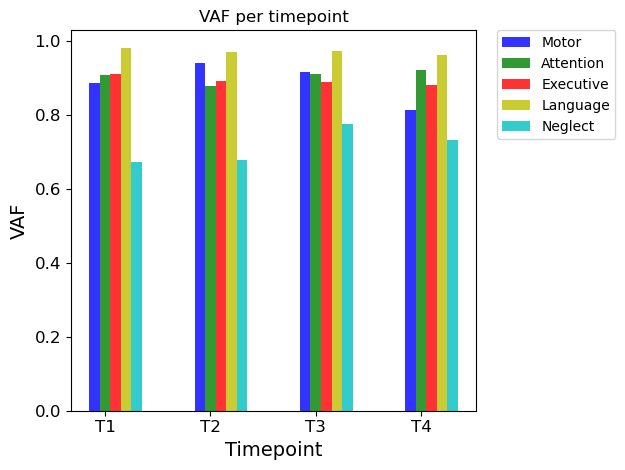

In [28]:
# plot the VAF

# data to plot
n_groups = 4
# create plot
fig, ax = plt.subplots()      
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, [vaf[0][0], vaf[1][0], vaf[2][0], vaf[3][0]], bar_width,
alpha=opacity,
color='b',
label='Motor')

rects2 = plt.bar(index + bar_width, [vaf[0][1], vaf[1][1], vaf[2][1], vaf[3][1]], bar_width,
alpha=opacity,
color='g',
label='Attention')

rects3 = plt.bar(index + bar_width*2, [vaf[0][2], vaf[1][2], vaf[2][2], vaf[3][2]], bar_width,
alpha=opacity,
color='r',
label='Executive')

rects4 = plt.bar(index + bar_width*3, [vaf[0][3], vaf[1][3], vaf[2][3], vaf[3][3]], bar_width,
alpha=opacity,
color='y',
label='Language')

rects5 = plt.bar(index + bar_width*4, [vaf[0][4], vaf[1][4], vaf[2][4], vaf[3][4]], bar_width,
alpha=opacity,
color='c',
label='Neglect')

if not merge_memory_executive:
    rects6 = plt.bar(index + bar_width*5, [vaf[0][5], vaf[1][5], vaf[2][5], vaf[3][5]], bar_width,
    alpha=opacity,
    color='m',
    label='Memory')

plt.xlabel('Timepoint')
plt.ylabel('VAF')
plt.title('VAF per timepoint')
plt.xticks(index + bar_width, ('T1', 'T2', 'T3', 'T4'))


# move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

# Clustering

In [29]:
# List of the domains we want to use for the clustering
col_list_clustering = ['motor','attention', 'executive', 'sensory', 'language']
if not merge_memory_executive:
    col_list_clustering = col_list_clustering + ['memory']

### Look for the best number of clusters at timepoint 1

#################################################### Timepoint 1 ########################################################
Index(['motor', 'attention', 'executive', 'sensory', 'language'], dtype='object')
(74, 5)
           motor  attention  executive    sensory   language
count  74.000000  74.000000  74.000000  74.000000  74.000000
mean    0.177198   0.288016   0.442553   0.090051   0.550856
std     0.283949   0.223292   0.211262   0.178959   0.164580
min     0.000000   0.000000   0.000000   0.000000   0.000000
25%     0.018320   0.113206   0.279783   0.000000   0.444296
50%     0.048979   0.219767   0.421883   0.022546   0.554138
75%     0.109119   0.399361   0.574094   0.091164   0.653783
max     1.000000   1.000000   1.000000   1.000000   1.000000
 
Index(['motor', 'attention', 'executive', 'sensory', 'language'], dtype='object')


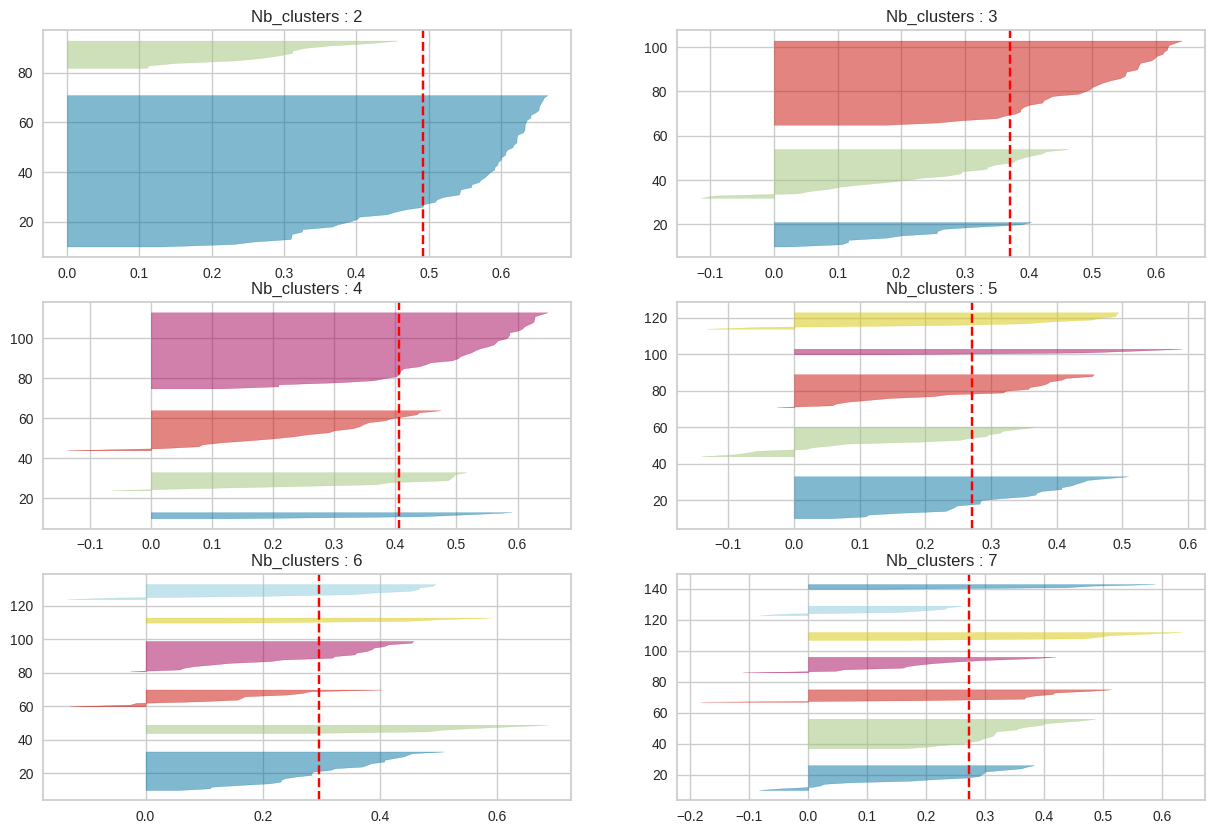

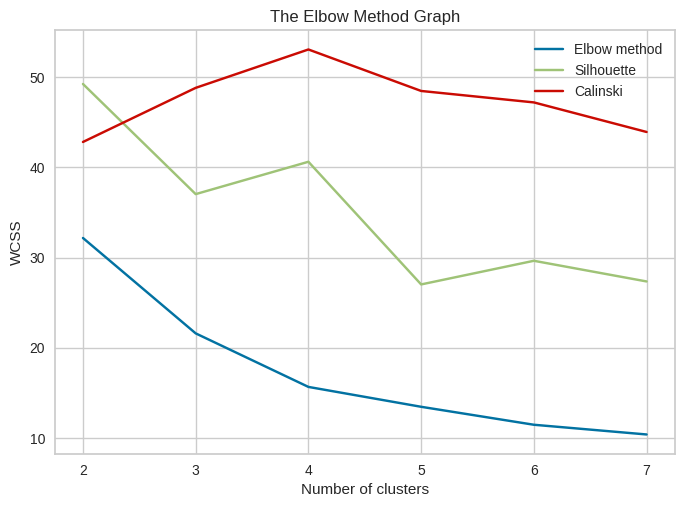

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score

# min max normalization of the NMF features before clustering
scaler = MinMaxScaler()

distances = []

timepoint = 0

print('#################################################### Timepoint',str(timepoint+1),'########################################################')

# uncomment to normalise
X = NMF_per_timepoint[timepoint][col_list_clustering]

col = X.columns
print(col)

# fit on timepoint 1, transform on the others
X = scaler.fit_transform(X)
    
# convert the array to a dataframe
X = pd.DataFrame(X)
X.columns = col


print(X.shape)
print(X.describe())
print(' ')
print(X.columns)

nb_clusters = 8

# Create an empty list
wcss=[]
sil = []
calinski = []

fig, ax = plt.subplots(3, 2, figsize=(15,10))

# Loop to fill the WCSS list for each nb of clusters
for i in range(2,nb_clusters):
    kmeans_test = KMeans(init='random', n_clusters=i, n_init=10,
                max_iter=300, random_state=42)
    kmeans_test.fit(X)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(kmeans_test, colors='yellowbrick', ax=ax[q-1][mod], init = 'k_means++')
    visualizer.fit(X)
    ax[q-1, mod].title.set_text("Nb_clusters : "+ str(i))

    wcss.append(kmeans_test.inertia_*3)
    sil.append(silhouette_score(X,kmeans_test.labels_)/0.01)
    calinski.append(calinski_harabasz_score(X, kmeans_test.labels_))


# plot silhouette graphs
plt.show()
fig.tight_layout()

range_ = range(2,nb_clusters)

# Plot the resume of WCSS values comparing to nb of clusters
plt.plot(range_,wcss, label = 'Elbow method')
plt.legend(loc='upper center')
plt.plot(range_,sil, label = 'Silhouette')
plt.legend(loc='upper center')
plt.plot(range_,calinski, label = 'Calinski')
plt.legend(loc='upper right')
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# save the plot
plt.show()

Based on the best number of clusters found above (in this case 4), we can now apply the KMeans algorithm to T1, and then classify patients from the other timepoints based on the centroids of the clusters found at T1:

In [31]:
from sklearn.cluster import KMeans

# min max normalization of the NMF features before clustering
scaler = MinMaxScaler()

probabilities = []

for timepoint in range(0,4):

    print('####################################################',str(timepoint+1),'########################################################')

    X = NMF_per_timepoint[timepoint][col_list_clustering]
     
    # uncomment to normalise
    col = X.columns

    # fit on timepoint 1, transform on the others
    if timepoint == 0:
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
        
    # convert the array to a dataframe
    X = pd.DataFrame(X)
    X.columns = col

    print(X.shape)
    # measure the mean and std of NMF_df
    display(X.describe())
    print(' ')
    print(X.columns)
    

    # keep clusters of timepoint 1 only 
    if timepoint == 0:

        n_clusters = 4
        kmeans = KMeans(n_clusters=n_clusters,init ='k-means++', max_iter=100, n_init=10,random_state=42).fit(X)
        centers = kmeans.cluster_centers_

    #get labels
    labels = kmeans.predict(X)

    # Initialize list to hold information about each cluster in order to later sort the clusters
    cluster_info = []
    labels_name = np.unique(labels)
    print(labels_name)

    for i in labels_name:
        # Identifying indices of points belonging to the current cluster
        cluster_points_indices = np.where(labels == i)[0]
        print(cluster_points_indices)
        # Selecting the actual points belonging to the current cluster
        cluster_points = X.iloc[cluster_points_indices]

        # Adding information about the current cluster to the list
        cluster_info.append({
            'cluster_index': i,
            'cluster_points': cluster_points, 
            'cluster_indices_in_data': cluster_points_indices.tolist()
        })

    # Sorting the clusters based on the number of points they contain
    sorted_cluster_info = sorted(cluster_info, key=lambda x: len(x['cluster_points']), reverse=True)

    #map label to ordered labels
    ordered_labels = {sorted_cluster_info[i]['cluster_index'] : i for i in range(len(sorted_cluster_info))}

    # measure distances between each patient and the centroids of timepoint 1
    dist = np.zeros((X.shape[0], n_clusters))
    for k in range(n_clusters):
        dist[:, k] = np.linalg.norm(X - centers[k], axis=1)
    
    # compute the probability of each patient to belong to each cluster
    sum_distances = np.sum(dist, axis=1)
    proba = (1 - dist / sum_distances[:, None])/(n_clusters-1)

    # store the probabilities
    probabilities.append(proba)
    
    # transform labels list into list with ordered labels
    ordered_labels_list = [ordered_labels[label] for label in labels]
    # measure labels based on the clusters of timepoint 1
    NMF_per_timepoint[timepoint]['Labels'] = ordered_labels_list




#################################################### 1 ########################################################
(74, 5)


,motor,attention,executive,sensory,language
count,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.177198,0.288016,0.442553,0.090051,0.550856
std,0.283949,0.223292,0.211262,0.178959,0.164580
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018320,0.113206,0.279783,0.000000,0.444296
50%,0.048979,0.219767,0.421883,0.022546,0.554138
75%,0.109119,0.399361,0.574094,0.091164,0.653783
max,1.000000,1.000000,1.000000,1.000000,1.000000


 
Index(['motor', 'attention', 'executive', 'sensory', 'language'], dtype='object')
[0 1 2 3]
[48 49 57 66]
[ 0  1  2  3  4  6 10 11 12 13 14 15 16 19 20 24 25 26 27 29 30 35 36 37
 38 40 42 43 46 47 50 52 53 58 59 61 62 67 71 72]
[ 5  7  8  9 18 22 28 32 33 39 41 45 54 55 60 63 68 69 70 73]
[17 21 23 31 34 44 51 56 64 65]
#################################################### 2 ########################################################
(64, 5)


,motor,attention,executive,sensory,language
count,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.141502,0.224699,0.400180,0.106191,0.607727
std,0.253976,0.213506,0.208017,0.356962,0.170287
min,0.000000,-0.020663,-0.025750,0.000000,0.239622
25%,0.011192,0.046720,0.233212,0.000000,0.479085
50%,0.033989,0.163808,0.389146,0.000000,0.615996
75%,0.090583,0.315803,0.517653,0.067638,0.699110
max,0.876061,0.969998,0.923269,2.096774,1.000000


 
Index(['motor', 'attention', 'executive', 'sensory', 'language'], dtype='object')
[0 1 2 3]
[40 52 62 63]
[ 0  1  2  3  4  9 10 11 12 13 14 15 18 19 20 23 24 25 26 27 29 32 33 34
 35 36 37 41 42 43 46 48 49 51 53 54 58 59 61]
[ 5  6  7  8 17 21 30 31 44 47 50 55 56 57 60]
[16 22 28 38 39 45]
#################################################### 3 ########################################################
(52, 5)


,motor,attention,executive,sensory,language
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.063961,0.218090,0.332236,0.022186,0.385560
std,0.148824,0.186713,0.169951,0.048411,0.190017
min,0.000000,-0.074262,-0.091271,0.000000,-0.098737
25%,0.005144,0.055867,0.206576,0.000000,0.281838
50%,0.021809,0.157014,0.322716,0.000000,0.352938
75%,0.054833,0.337940,0.468937,0.024315,0.539649
max,0.876061,0.617703,0.698565,0.299539,0.816241


 
Index(['motor', 'attention', 'executive', 'sensory', 'language'], dtype='object')
[1 2 3]
[ 0  1  2  3  5  6  7  8  9 10 11 14 15 17 18 19 21 22 23 24 25 26 27 28
 29 30 31 34 35 36 37 39 40 41 42 44 45 49 50 51]
[ 4 13 16 20 32 33 38 46 47 48]
[12 43]
#################################################### 4 ########################################################
(46, 5)


,motor,attention,executive,sensory,language
count,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.033177,0.138900,0.320175,0.012955,0.473247
std,0.081533,0.142912,0.172936,0.029650,0.157043
min,0.000000,-0.268552,-0.045728,0.000000,0.173858
25%,0.002355,0.051834,0.202950,0.000000,0.337451
50%,0.015225,0.126646,0.290706,0.000000,0.467027
75%,0.029012,0.171843,0.438240,0.000000,0.567626
max,0.549041,0.534529,0.752319,0.142962,0.853029


 
Index(['motor', 'attention', 'executive', 'sensory', 'language'], dtype='object')
[1 2 3]
[ 0  1  2  3  4  5  7  8  9 10 11 12 14 15 16 17 18 19 20 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 38 39 40 41 44]
[ 6 21 22 37 42 43 45]
[13]


### Plot the clusters

Size of each cluster in PERCENTAGE:
Labels
0    40
1    20
2    10
3     4
Name: count, dtype: int64


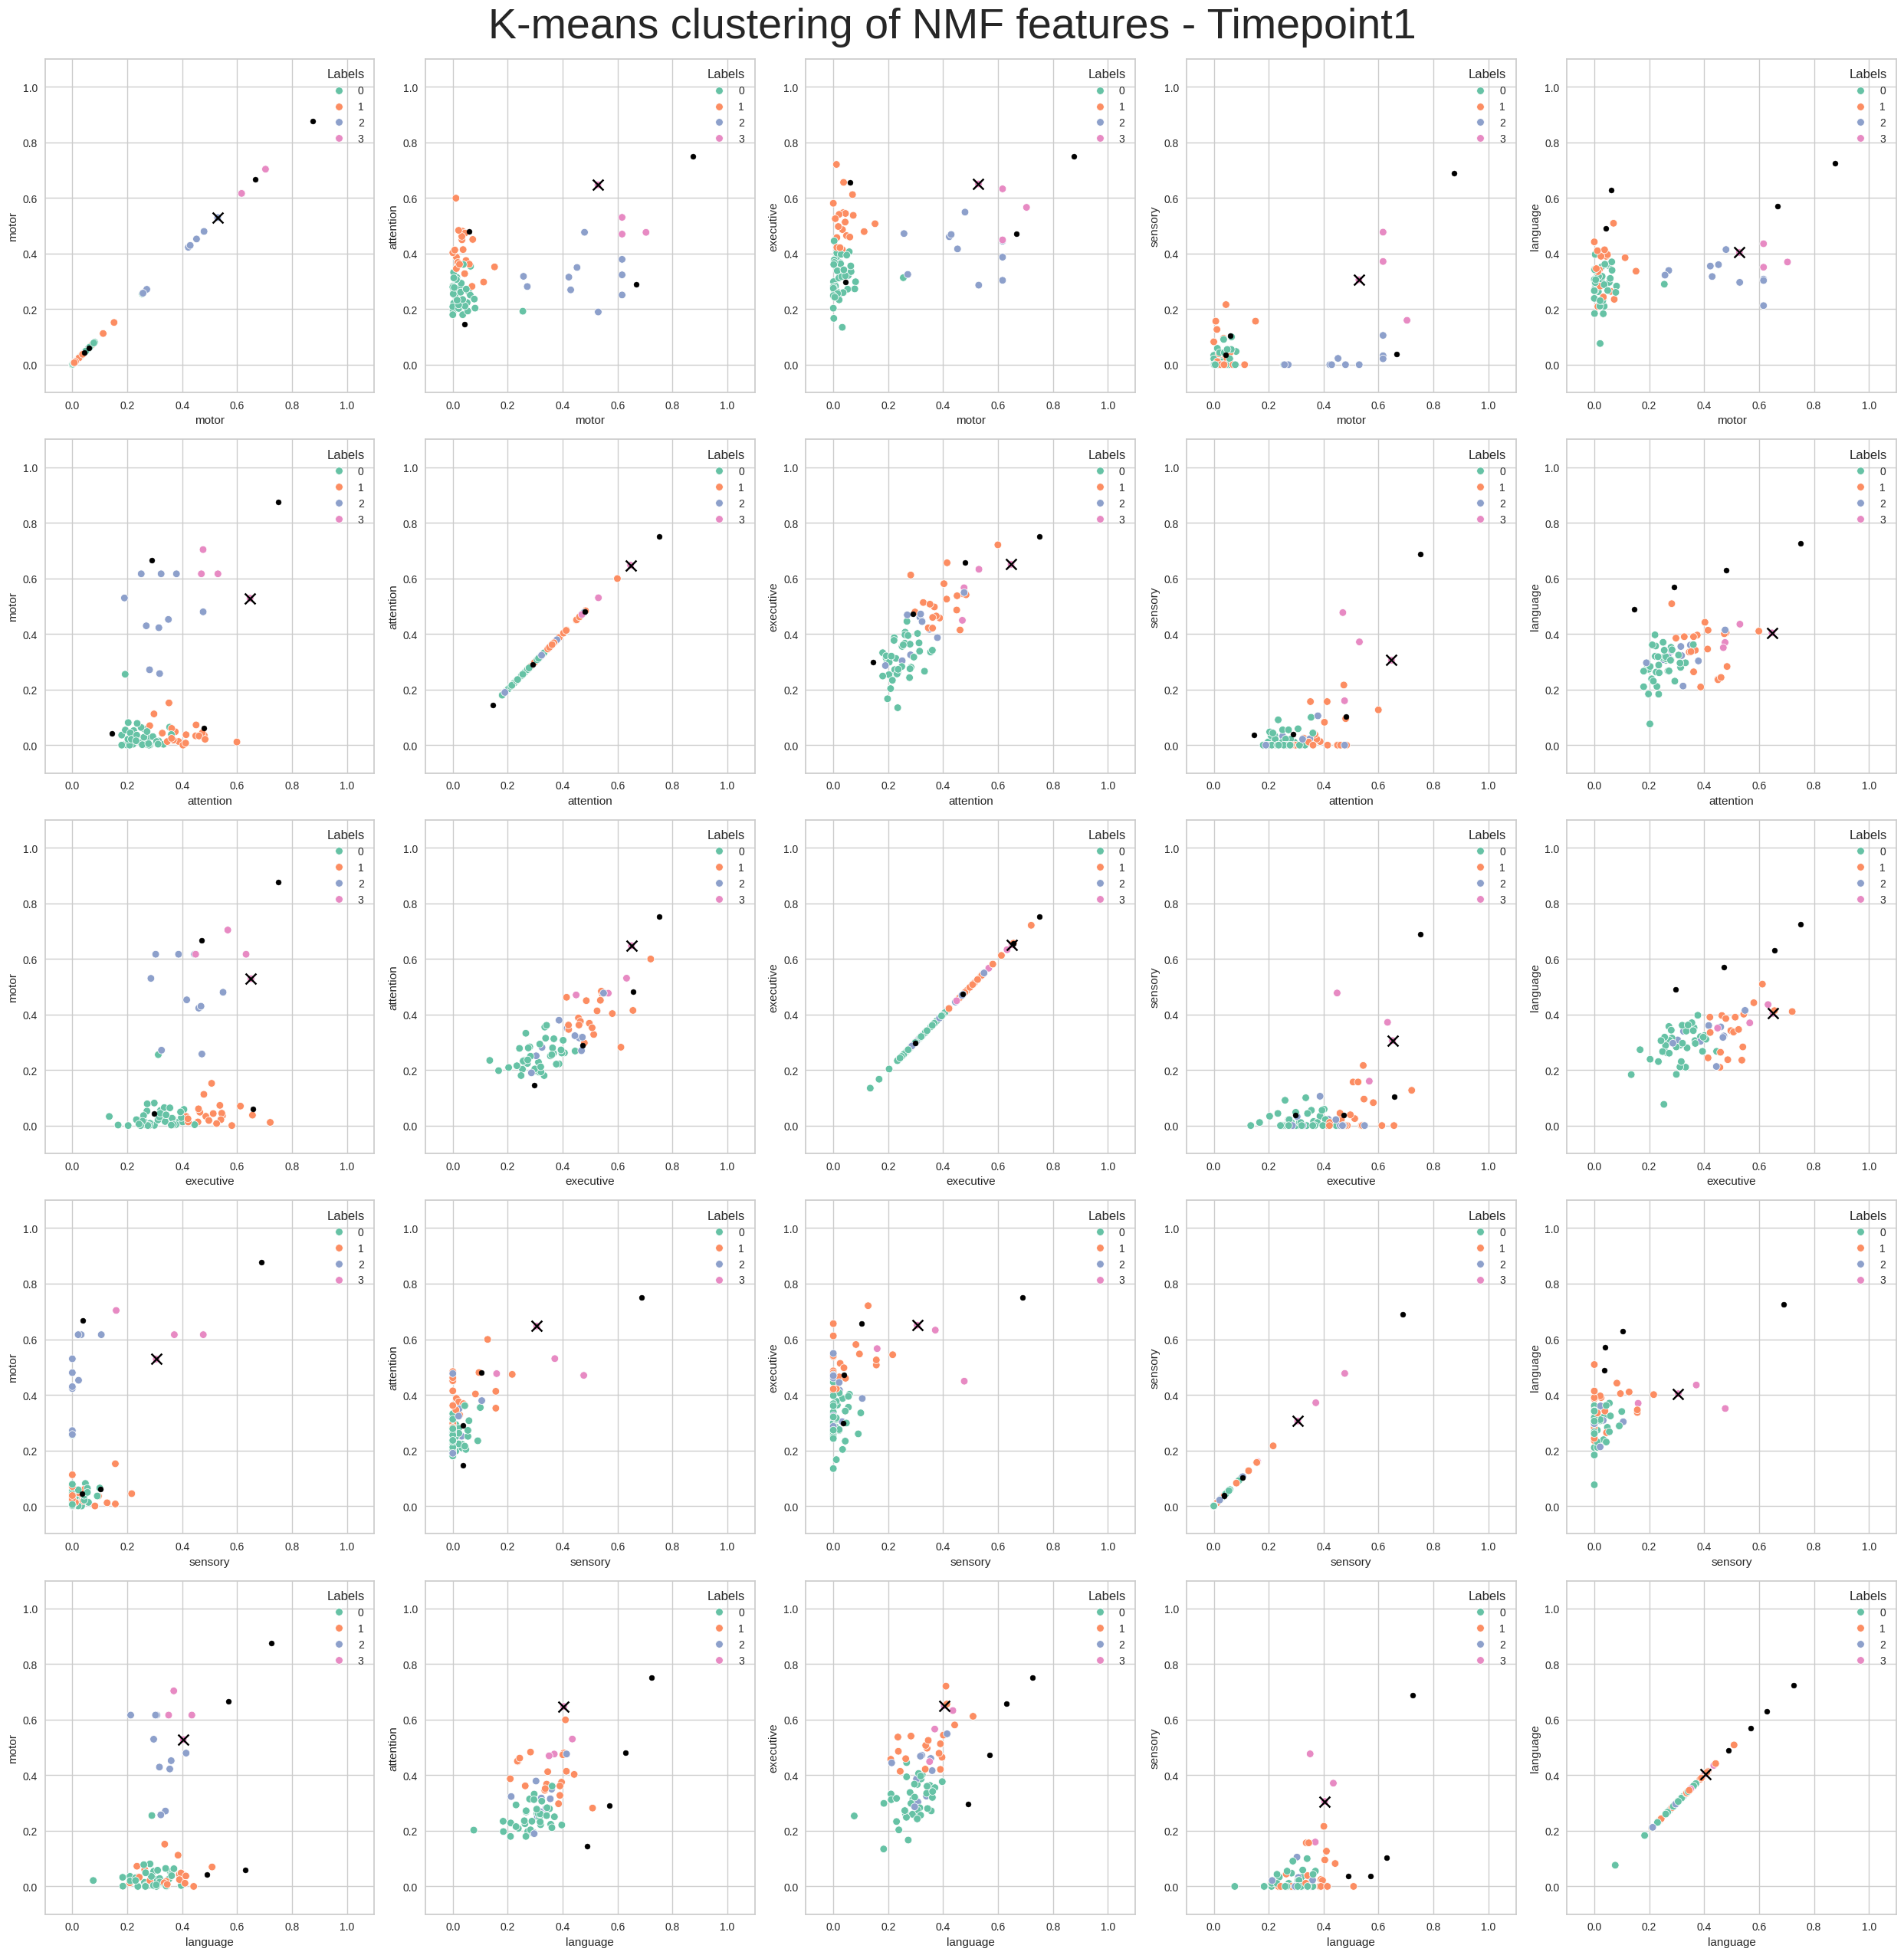

Size of each cluster in PERCENTAGE:
Labels
0    39
1    15
2     6
3     4
Name: count, dtype: int64


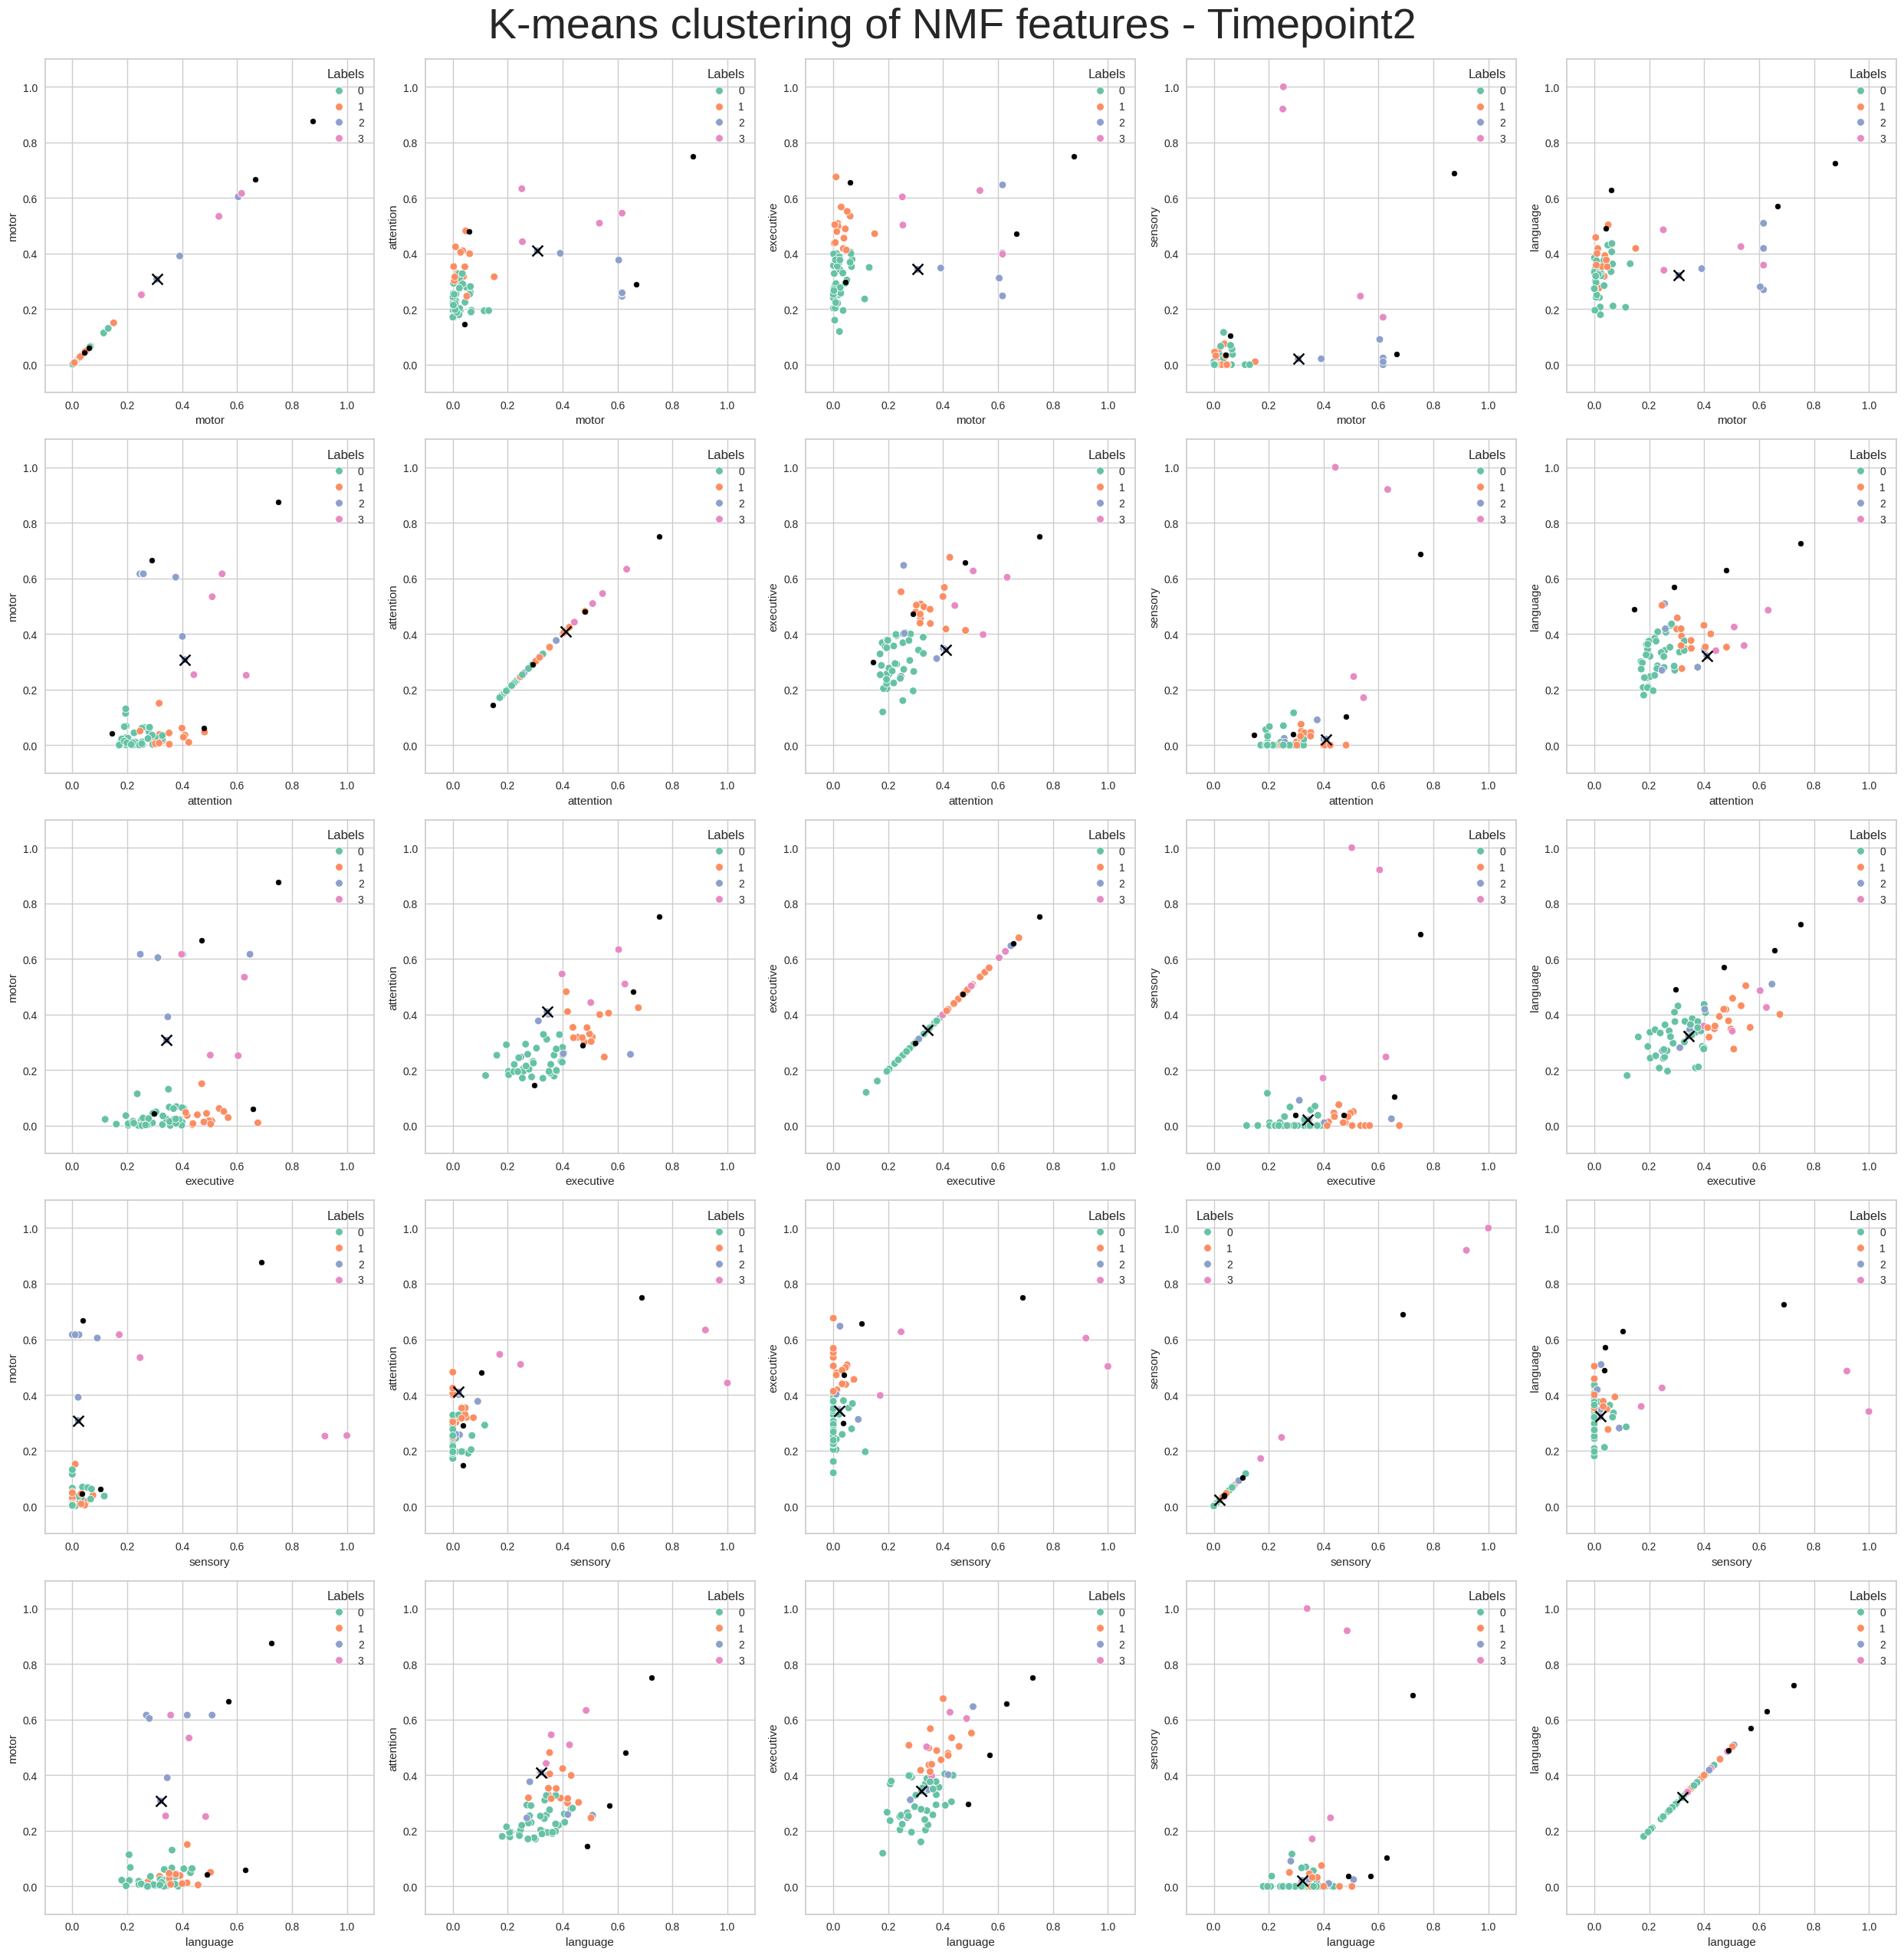

Size of each cluster in PERCENTAGE:
Labels
0    40
1    10
2     2
Name: count, dtype: int64


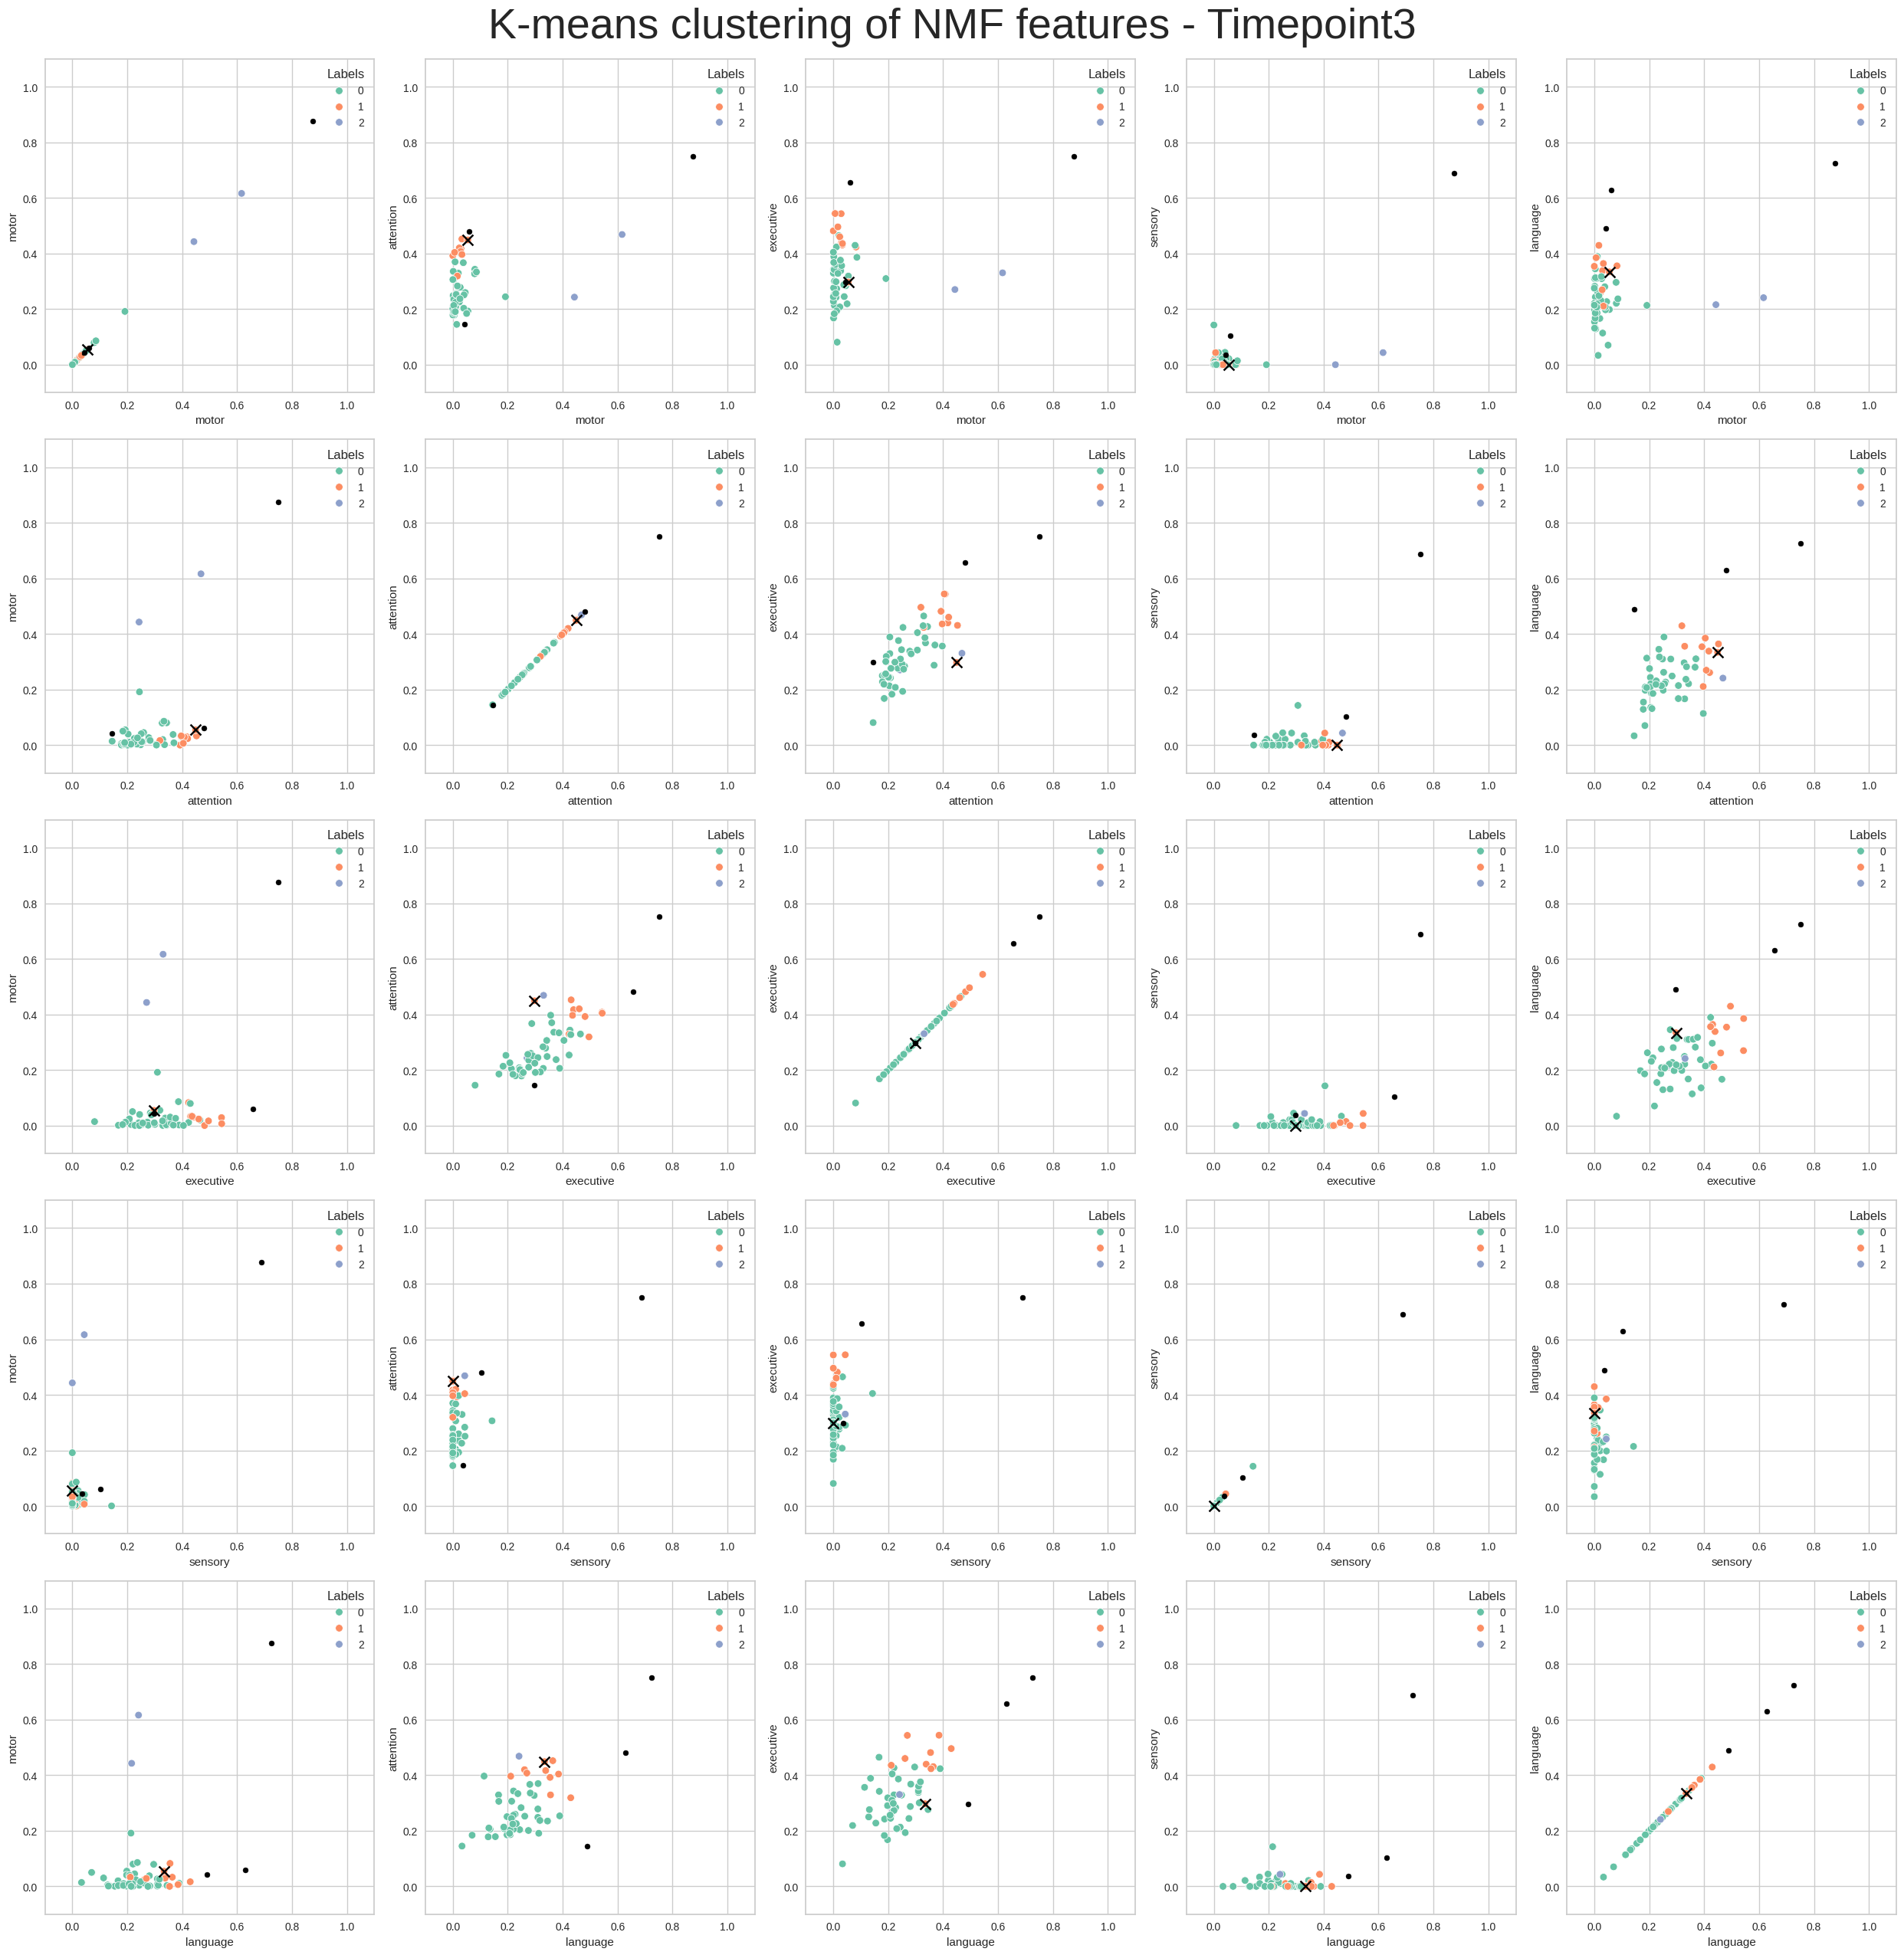

Size of each cluster in PERCENTAGE:
Labels
0    38
1     7
2     1
Name: count, dtype: int64


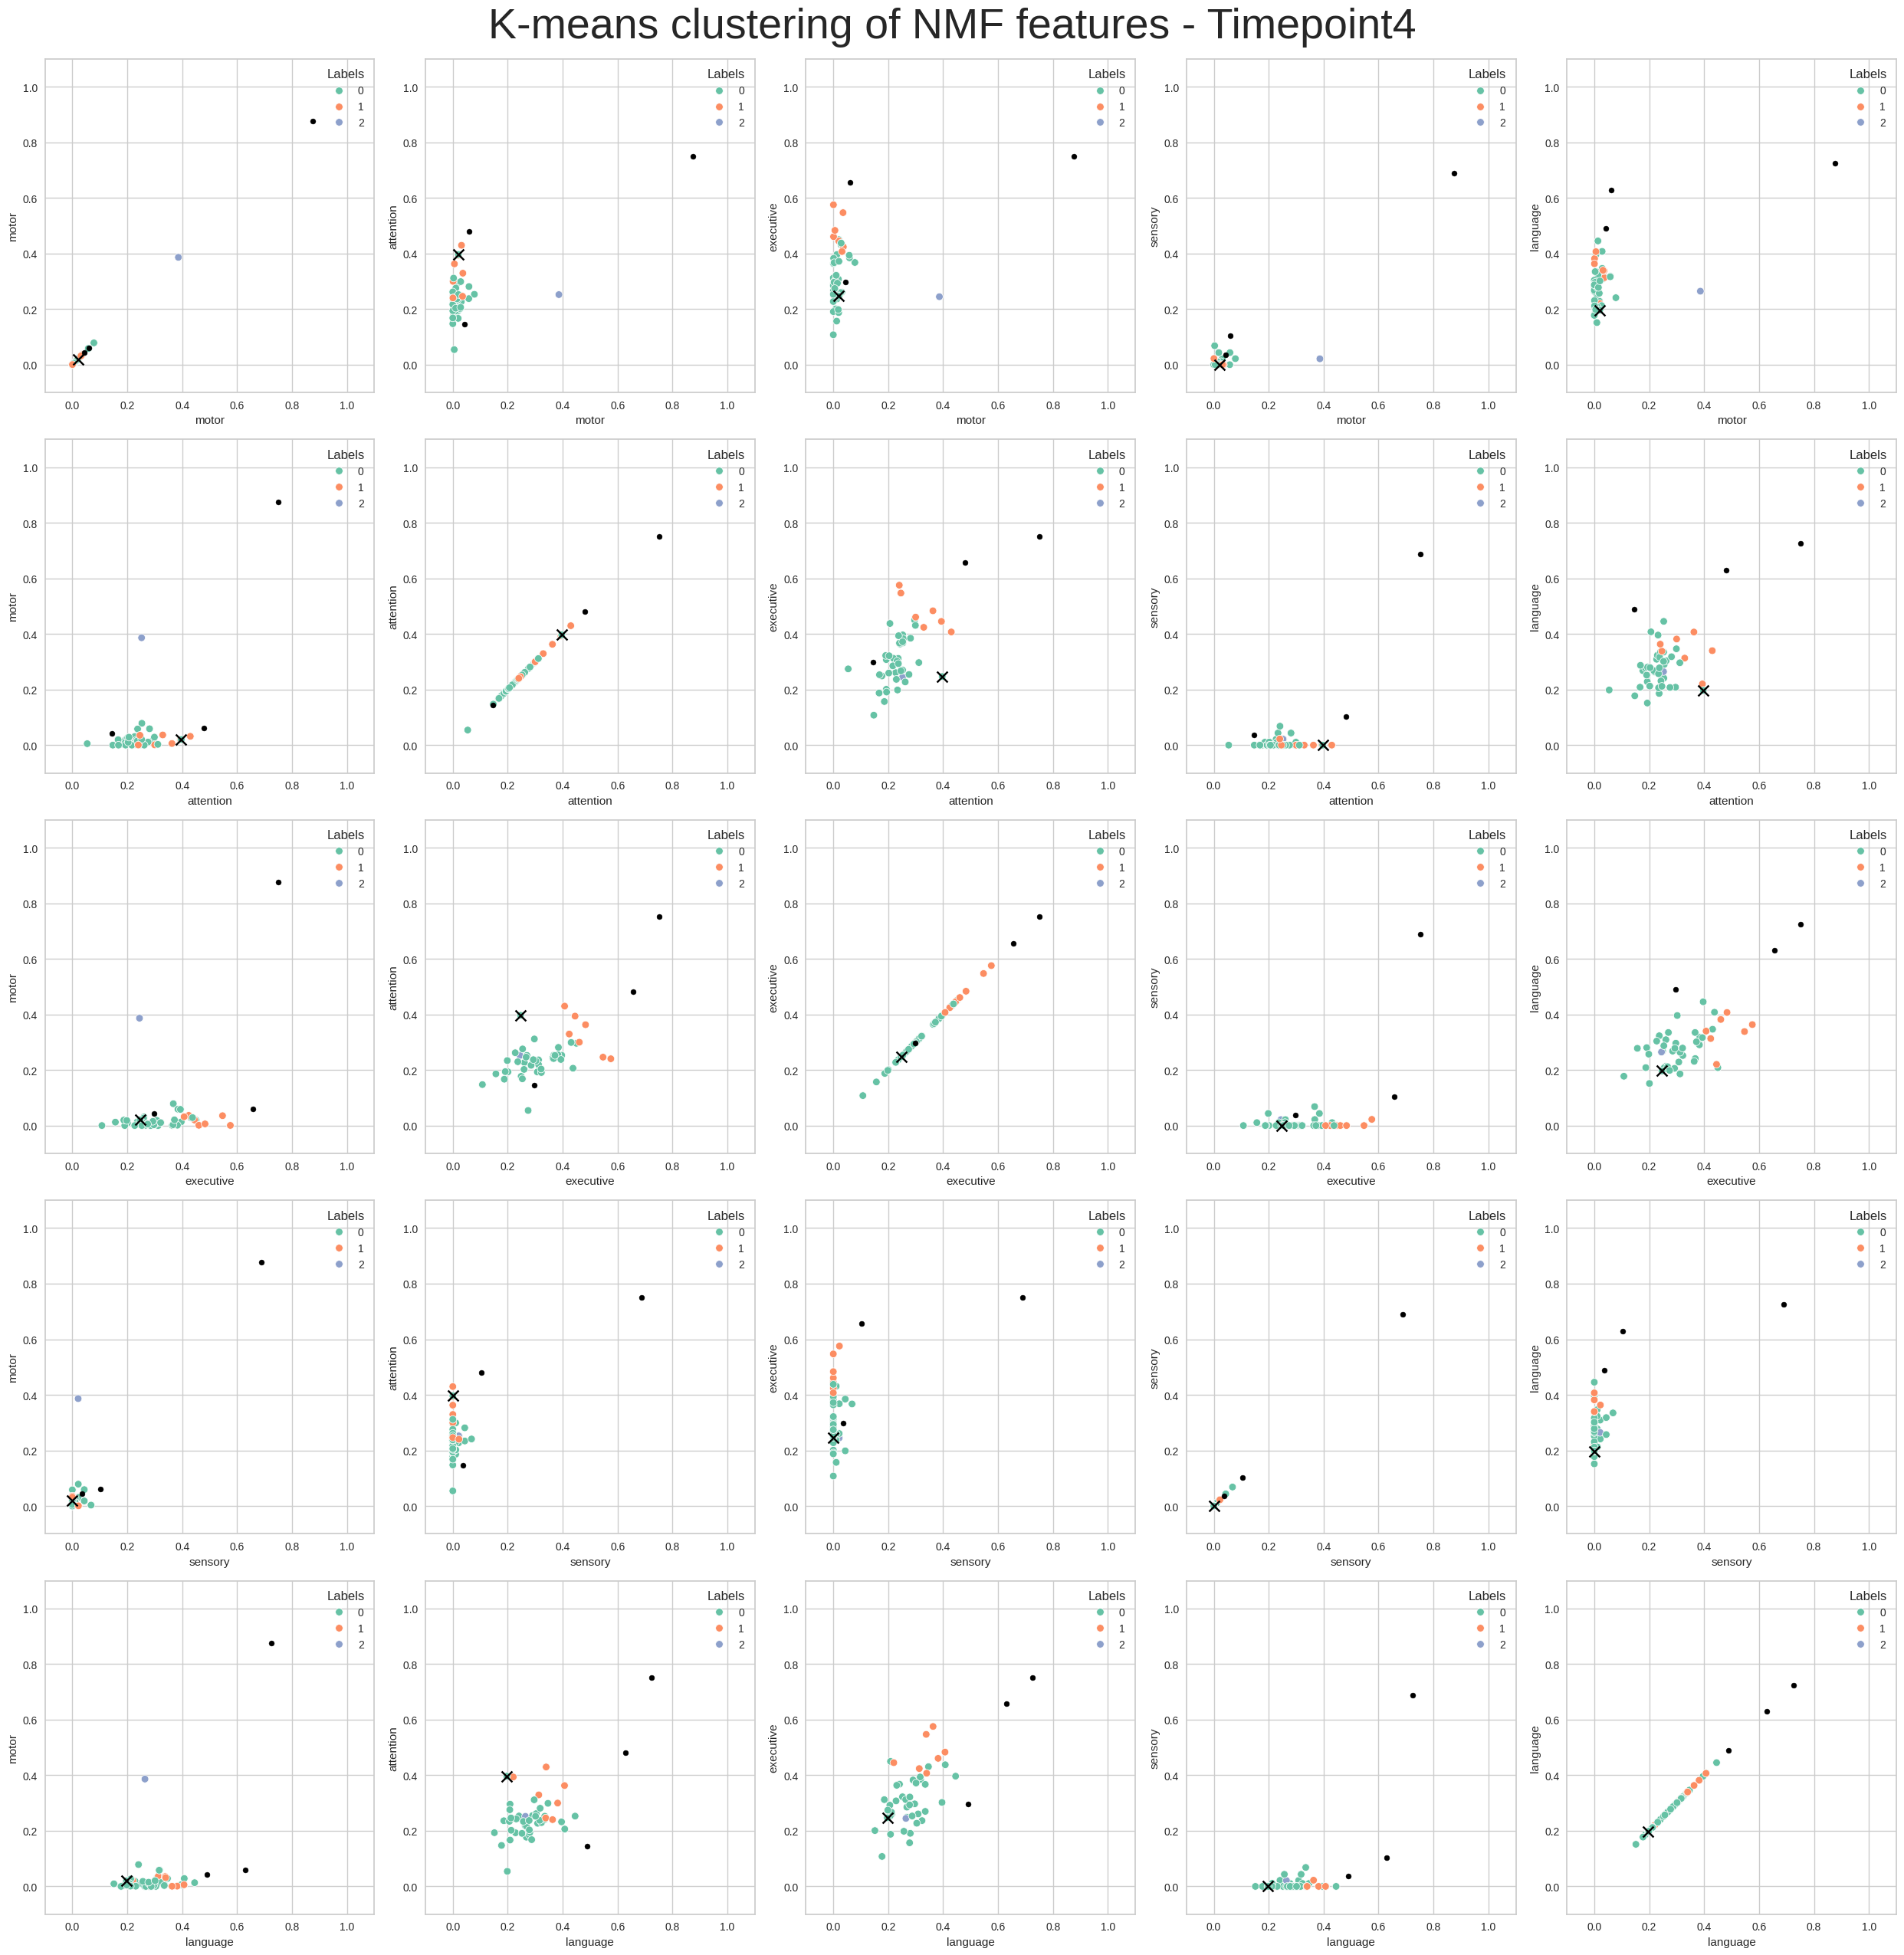

In [32]:
for timepoint in range(0,4):

    X = NMF_per_timepoint[timepoint][col_list_clustering + ['Labels']]

    print('Size of each cluster in PERCENTAGE:')
    print(X['Labels'].value_counts())
    #print(round(X['Labels'].value_counts(normalize=True)*100,2))


    shape = X.shape[1]-1
    # Create the figures and the axes
    fig,axs = plt.subplots(shape,shape, figsize=(25,25))

    n = len(np.unique(X['Labels']))

    # Loop to fill the figures
    for i in range(shape):
        for j in range(shape):
        
            sns.scatterplot(ax = axs[i,j], data=X, x=X.columns[i],y=X.columns[j],hue='Labels', palette = sns.color_palette("Set2"))


            axs[i,j].set_xlabel(str(X.columns[i]))
            axs[i,j].set_ylabel(str(X.columns[j]))

            # plot the centroids of timepoint 1 with a black dots
            for k in range(0,n):
                axs[i,j].scatter(centers[k][i],centers[k][j],marker='.',color='black',s=100)
            
            # THIS CAN BE REMOVED IF NOT NEEDED: plot the patient P055 with a black cross
            axs[i,j].scatter(NMF_per_timepoint[timepoint][NMF_per_timepoint[timepoint]['Patient'] == 'P055'].iloc[0][i],NMF_per_timepoint[timepoint][NMF_per_timepoint[timepoint]['Patient'] == 'P055'].iloc[0][j],marker="x",color='black',s=100)

    # block all axis between 0 and 1
    for ax in axs.flat:
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(-0.1,1.1)
        
    # add title
    fig.tight_layout()

    # show legend
    fig.suptitle('K-means clustering of NMF features - Timepoint'+str(timepoint+1), fontsize=40, y=1.02)
    plt.show()  

# Let's look at a specific patients

In [33]:
# In order to plot the evolution of specific patients
# convert probabilities to dataframe
probabilities_time_1= pd.DataFrame(probabilities[0])
probabilities_time_2= pd.DataFrame(probabilities[1])
probabilities_time_3= pd.DataFrame(probabilities[2])
probabilities_time_4= pd.DataFrame(probabilities[3])

# rename columns
col_names = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
probabilities_time_1.columns = col_names
probabilities_time_2.columns = col_names
probabilities_time_3.columns = col_names
probabilities_time_4.columns = col_names

# add patient ID
probabilities_time_1['Patient'] = NMF_per_timepoint[0]['Patient']
probabilities_time_2['Patient'] = NMF_per_timepoint[1]['Patient']
probabilities_time_3['Patient'] = NMF_per_timepoint[2]['Patient']
probabilities_time_4['Patient'] = NMF_per_timepoint[3]['Patient']

By curiosity, look for patients highly affected on the sensory domain:

In [34]:
# return patient with sensory above 0.4 
print(NMF_per_timepoint[0][NMF_per_timepoint[0]['motor']>0.6])


       motor  attention  executive   sensory  language   neglect Patient  \
17  0.616390   0.250894   0.303605  0.032258  0.308019  0.098964    P019   
31  0.616390   0.379135   0.386879  0.105466  0.302988  0.065383    P035   
49  0.703592   0.476206   0.566184  0.159634  0.369471  0.166058    P056   
56  0.616390   0.323320   0.444584  0.021277  0.212579  0.029364    P063   
57  0.616390   0.530259   0.632791  0.371429  0.435299  0.440394    P064   
66  0.616390   0.469939   0.449094  0.476923  0.350747  0.158380    P074   

    Labels  
17       2  
31       2  
49       3  
56       2  
57       3  
66       3  


Since patient P019 is on the list, let's check if he is present at all timepoints

In [35]:
# look for patient P056 in timepoint 1, 2 and 3
print(NMF_per_timepoint[1][NMF_per_timepoint[1]['Patient']=='P019'])
print(NMF_per_timepoint[2][NMF_per_timepoint[2]['Patient']=='P019'])
print(NMF_per_timepoint[3][NMF_per_timepoint[3]['Patient']=='P019'])

      motor  attention  executive  sensory  language   neglect Patient  Labels
16  0.61639   0.246263   0.247526      0.0  0.269497  0.047655    P019       2
       motor  attention  executive  sensory  language   neglect Patient  \
12  0.442885   0.243118   0.270482      0.0  0.215959  0.143519    P019   

    Labels  
12       2  
       motor  attention  executive   sensory  language   neglect Patient  \
13  0.386301   0.252177   0.244663  0.021277  0.264466  0.113629    P019   

    Labels  
13       2  


Let's analyse the evolution of the clusters for patient P019. As you can see below, the patient get's better (probability to remain in cluster 0 decreases), but he always remains in the same cluster:

Text(0, 0.5, 'Probability of belonging to a cluster')

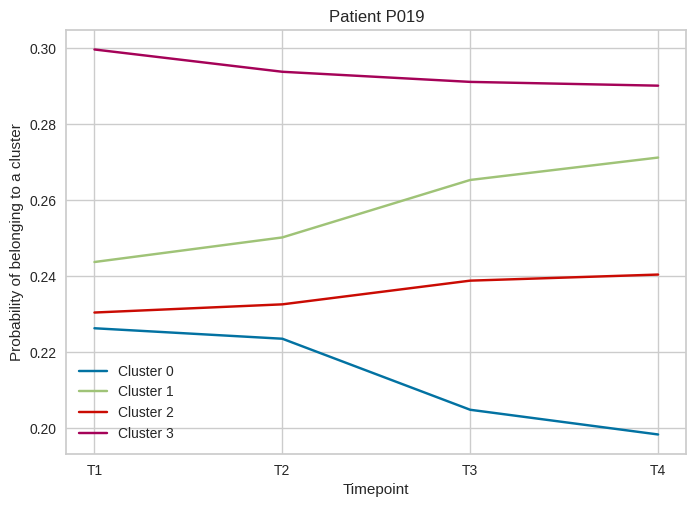

In [36]:
# plot the probabilities for patient P055
patient = 'P019'
time1 = probabilities_time_1[probabilities_time_1['Patient'] == patient]
time2  = probabilities_time_2[probabilities_time_2['Patient'] == patient]
time3  = probabilities_time_3[probabilities_time_3['Patient'] == patient]
time4  = probabilities_time_4[probabilities_time_4['Patient'] == patient]

# join time1 until time 4  as rows into one dataframe
time1 = pd.concat([time1, time2, time3, time4], ignore_index=True)

# add timepoint column
time1['Timepoint'] = ['T1','T2','T3','T4']

# plot the probabilities per timepoint
sns.lineplot(data=time1, x='Timepoint', y='Cluster 0', label='Cluster 0')
sns.lineplot(data=time1, x='Timepoint', y='Cluster 1', label='Cluster 1')
sns.lineplot(data=time1, x='Timepoint', y='Cluster 2', label='Cluster 2')
sns.lineplot(data=time1, x='Timepoint', y='Cluster 3', label='Cluster 3')


# Add name of the patient
plt.title('Patient '+patient)
# add legend x and y
plt.xlabel('Timepoint')
plt.ylabel('Probability of belonging to a cluster')


Let's look at the evolution of the clusters for patient P055. As you can see below, the patient gets better: goes from Cluster 3, to 0, to 1 and finally to 2.

Meaning of each cluster: 

-Cluster 0: Affected (motor, executive, attention)  but Not affected (sensory)\
-Cluster 1: Not affected (motor, sensory) but Affected (executive, attention)\
-Cluster 2: Not affected (sensory, motor, executive and attention)\
-Cluster 3: Affected (sensory, motor, executive and attention)\



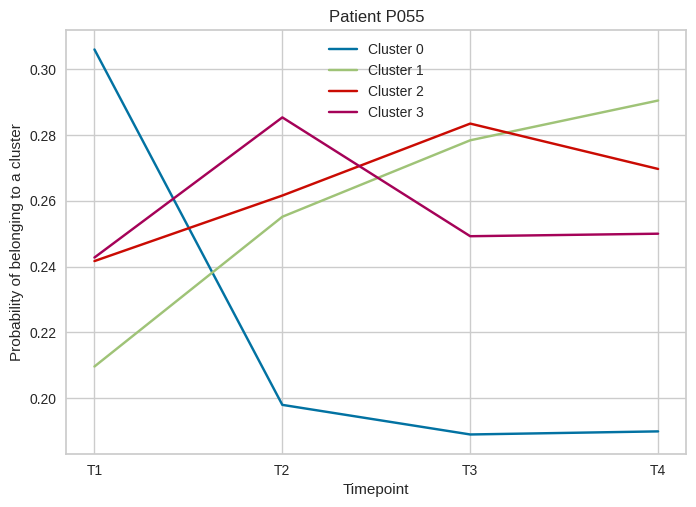

In [37]:
# plot the probabilities for patient P055
patient = 'P055'
time1 = probabilities_time_1[probabilities_time_1['Patient'] == patient]
time2  = probabilities_time_2[probabilities_time_2['Patient'] == patient]
time3  = probabilities_time_3[probabilities_time_3['Patient'] == patient]
time4  = probabilities_time_4[probabilities_time_4['Patient'] == patient]

# join time1 until time 4  as rows into one dataframe
# Concatenate vertically
time1 = pd.concat([time1, time2, time3, time4], ignore_index=True)

# add timepoint column
time1['Timepoint'] = ['T1','T2','T3','T4']

# plot the probabilities per timepoint
sns.lineplot(data=time1, x='Timepoint', y='Cluster 0', label='Cluster 0')
sns.lineplot(data=time1, x='Timepoint', y='Cluster 1', label='Cluster 1')
sns.lineplot(data=time1, x='Timepoint', y='Cluster 2', label='Cluster 2')
sns.lineplot(data=time1, x='Timepoint', y='Cluster 3', label='Cluster 3')


# Add name of the patient
plt.title('Patient '+patient)
# add legend x and y
plt.xlabel('Timepoint')
plt.ylabel('Probability of belonging to a cluster')
plt.show()
    

# Save the new datasets 

In [38]:
# save this dataframe
csv_path = "../Lisa/"
file_name = "NMF_per_timepoint"

if merge_memory_executive:
    file_name = file_name + "_merge"
if include_LAST_scores:
    file_name = file_name + "_LAST"
if LAST_scores_no_language:
    file_name = file_name + "_only_LAST"
for i in range(4):
    if LAST_scores_no_language:    
        NMF_per_timepoint[i]["language"] = norm_data[norm_data['Timepoint'] == i+1]["LAST_TOTAL_norm"]
    NMF_per_timepoint[i].to_csv(csv_path + file_name + "_" + str(i) + ".csv")
